In [44]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Likelihood_contours, Median_w_Error_cont, Gauss_dist, boot_to_posterior
from spec_exam import Gen_spec
from spec_id import *
from sim_engine import *
from spec_stats import Highest_density_region, Linear_fit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from spec_tools import Rescale_sfh, lbt_to_z, Posterior_spec
from prospect.models.transforms import logsfr_ratios_to_masses
from time import time
import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde
import img_scale

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20 and AGN == "-"')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')

# Examine fits

In [10]:
[U[0] for U in morph_db.Z_hci]

([[0.6427262520689969, 0.8671865202330316],
  [1.1944661848436977, 1.577536811960061],
  [0.6516357102494938, 0.9647152625060016],
  [0.9122671008283152, 1.097094323705967],
  [0.7544230763540225, 1.042650243255692],
  [1.2292647132981889, 1.442159500213116],
  [1.0499960901924643, 1.3935702529148686],
  [0.5184121410611915, 0.7980493166267904],
  [0.8417556959571767, 1.0559985282008886],
  [0.6613905628015446, 0.9829769697468576],
  [1.2016699388573366, 1.484205734849601],
  [0.9922519200446216, 1.2875876213051942],
  [0.9720021469855539, 1.312191324313671],
  [1.0627462731175734, 1.1459853096845132],
  [1.1703455749796192, 1.4006554938731828],
  [0.4162286486483845, 0.7279454696065564],
  [1.0978036546871, 1.4548073839401903],
  [0.3588920675186006, 0.7448300198817097],
  [0.7052534477656347, 0.875721633911595],
  [0.5251508146386832, 0.9435566802165518],
  [1.2879016014633065, 1.4259252474618351],
  [1.0095304014771052, 1.3557800025669766],
  [0.6787901877289578, 0.9367499212680676]

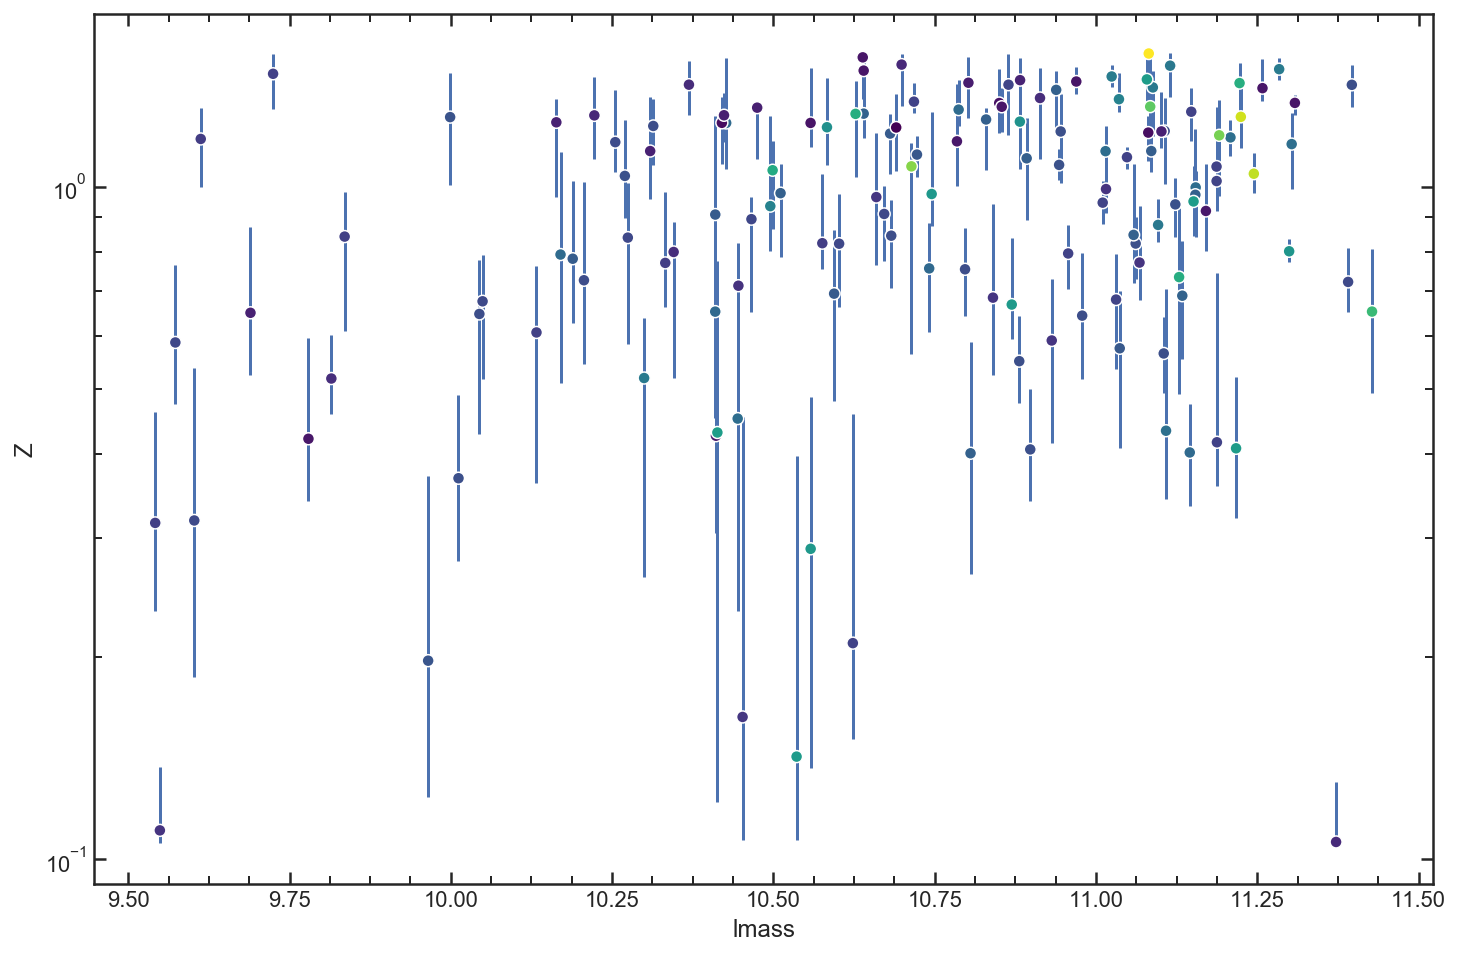

In [20]:
Zerrl = [U[0] for U in morph_db.Z_hci]
Zerrh = [U[1] for U in morph_db.Z_hci]

fig = plt.figure(figsize=[12,8])
ax = plt.subplot()
sea.scatterplot(morph_db.lmass,morph_db.Z, hue=morph_db.zgrism,
                     palette='viridis', sizes=(10, 200),legend=False, ax=ax, zorder =2)
plt.errorbar(morph_db.lmass, morph_db.Z, 
             yerr = [morph_db.Z - Zerrl, Zerrh - morph_db.Z], linestyle = 'none', zorder=1)
plt.yscale('log')

In [30]:
masses = np.linspace(9,12)
Z = np.log10(morph_db.Z.values)
Zerr_lin = [(U[1] - U[0])/2 for U in morph_db.Z_hci]
Zerr = Zerr_lin / (morph_db.Z.values * np.log(10))
lm = morph_db.lmass.values

def lfit_prior(u):
    m = 10*u[0] - 5
    b = 100*u[0] - 50
    return m,b

def lfit_likelihood(X):
    m, b = X
    line = interp1d(masses, m * masses + b)(lm)
    
    chi2 = np.sum(((Z - line) / Zerr)**2)
    
    return - chi2 / 2
    

In [45]:
sampler = dynesty.DynamicNestedSampler(lfit_likelihood, lfit_prior, ndim = 2, nlive_points = 4000,
                                         sample = 'rwalk', bound = 'multi',
                                        pool=Pool(processes=4), queue_size=4)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/utils.py:353: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/utils.py:353: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/utils.py:353: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/utils.py:353: RuntimeWarning: invalid value encountered in sqrt
  new_res.logzerr = np.sqrt(np.array(saved_logzvar))


In [46]:
sampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01,print_progress=True)


iter: 7858 | batch: 0 | bound: 350 | nc: 1 | ncall: 158047 | eff(%):  4.972 | loglstar:   -inf < -795.835 <    inf | logz: -805.925 +/-  0.138 | dlogz:  0.000 >  0.010            /Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynamicsampler.py:576: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),
iter: 8818 | batch: 1 | bound: 380 | nc: 25 | ncall: 182074 | eff(%):  4.843 | loglstar: -796.825 < -795.835 < -795.977 | logz: -805.925 +/-  0.138 | stop:  3.349            /Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynamicsampler.py:576: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),
iter: 9406 | batch: 2 | bound: 387 | nc: 25 | ncall: 196822 | eff(%):  4.779 | loglstar: -797.243 < -795.835 < -796.822 | logz: -805.930 +/-  0.140 | stop:  2.006            /Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site

In [47]:
dres = sampler.results


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynamicsampler.py:576: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),


(<Figure size 396x396 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a8c0d3f60>,
       dtype=object))

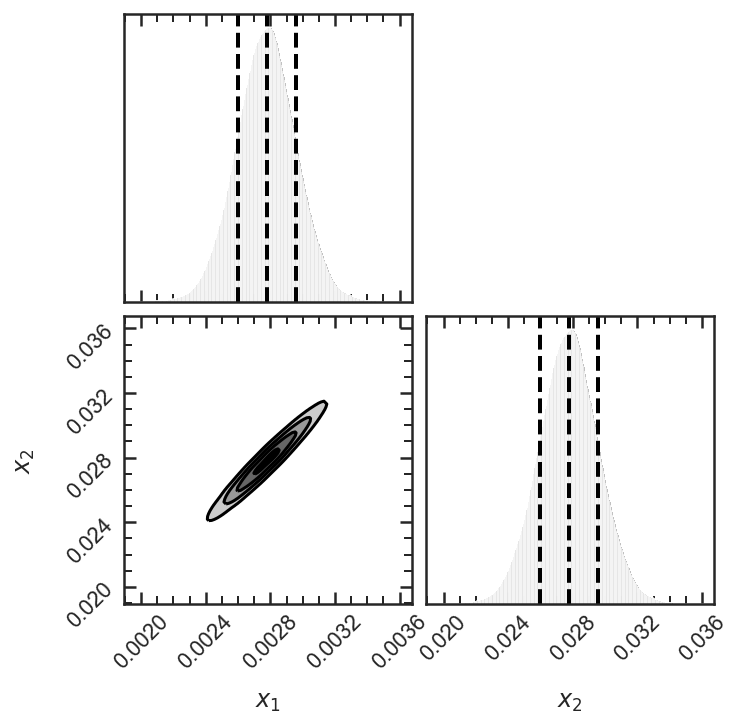

In [58]:
dyplot.cornerplot(dres)

In [69]:
m,Pm = Get_posterior(dres,0)
b,Pb = Get_posterior(dres,1)

In [72]:
from spec_tools import Gen_PPF
ppf_dict = {}
ppf_dict['pm'] = Gen_PPF(m,Pm)
ppf_dict['pb'] = Gen_PPF(b,Pb)

In [81]:
ln_grid = []
idx = 0
params = ['pm','pb']
trials = 1000
while idx < trials:
#     try:
    draw = np.zeros(2)

    for i in range(len(draw)):
        draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

    ln_grid.append(draw[0]*lm + draw[1])
        
    idx += 1
#     except:
#         pass
ln_grid = np.array(ln_grid)

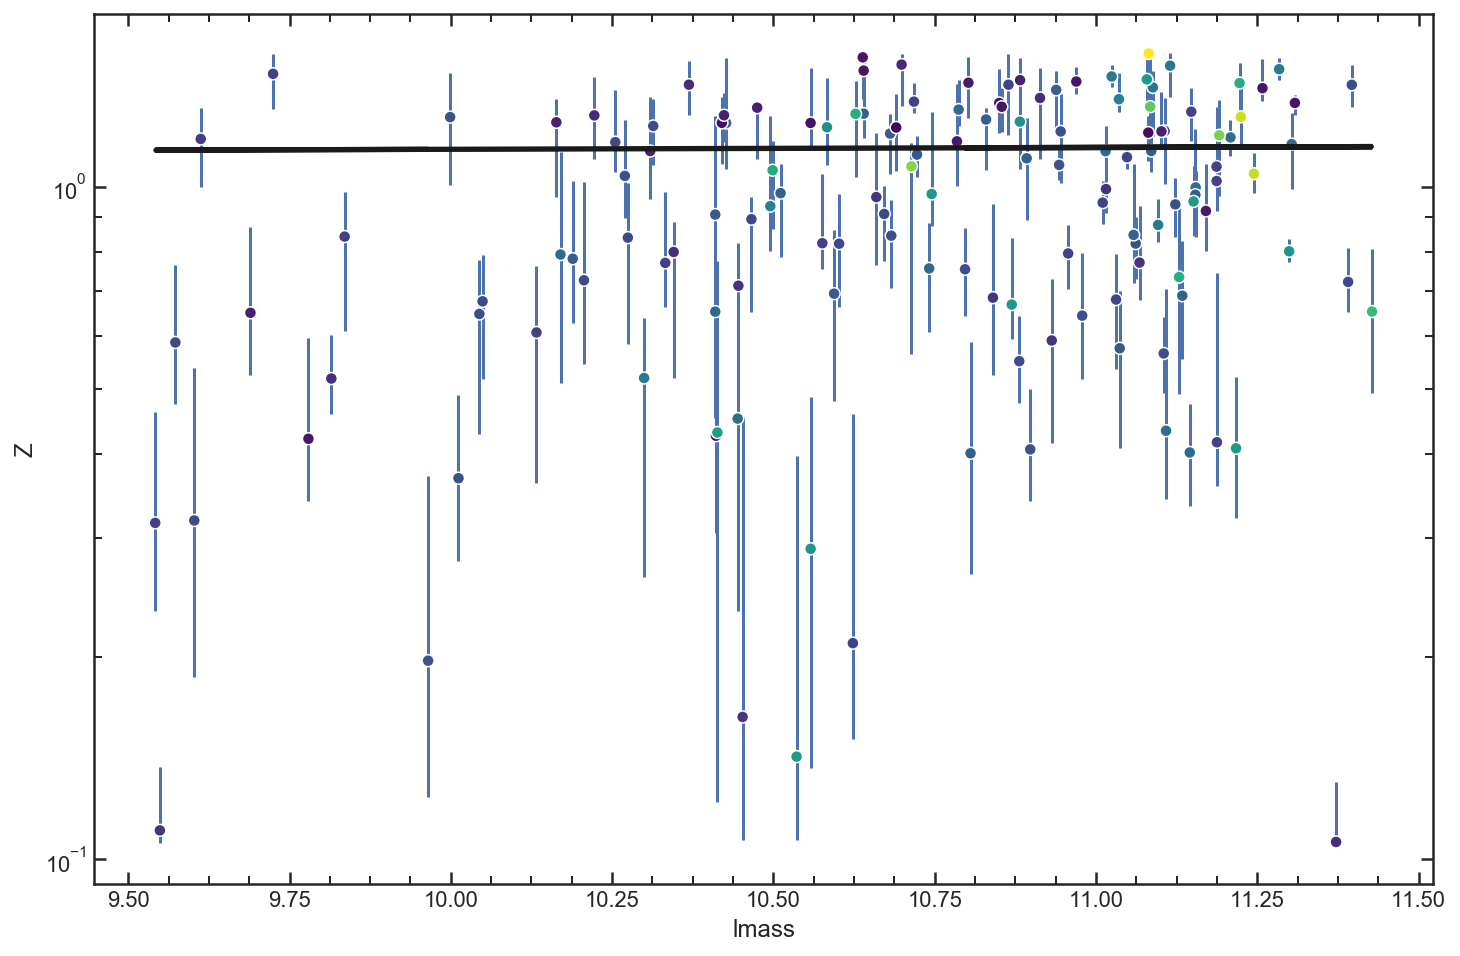

In [93]:
fig = plt.figure(figsize=[12,8])
ax = plt.subplot()
sea.scatterplot(morph_db.lmass,morph_db.Z, hue=morph_db.zgrism,
                     palette='viridis', sizes=(10, 200),legend=False, ax=ax, zorder =2)
plt.errorbar(morph_db.lmass, morph_db.Z, 
             yerr = [morph_db.Z - Zerrl, Zerrh - morph_db.Z], linestyle = 'none', zorder=1)
plt.yscale('log')

ax.plot(lm, 10**np.percentile(ln_grid,50, axis = 0), 'k', linewidth = 2)
ax.plot(lm, 10**np.percentile(ln_grid,16, axis = 0), 'k', linewidth = 1)
ax.plot(lm, 10**np.percentile(ln_grid,84, axis = 0), 'k', linewidth = 1)


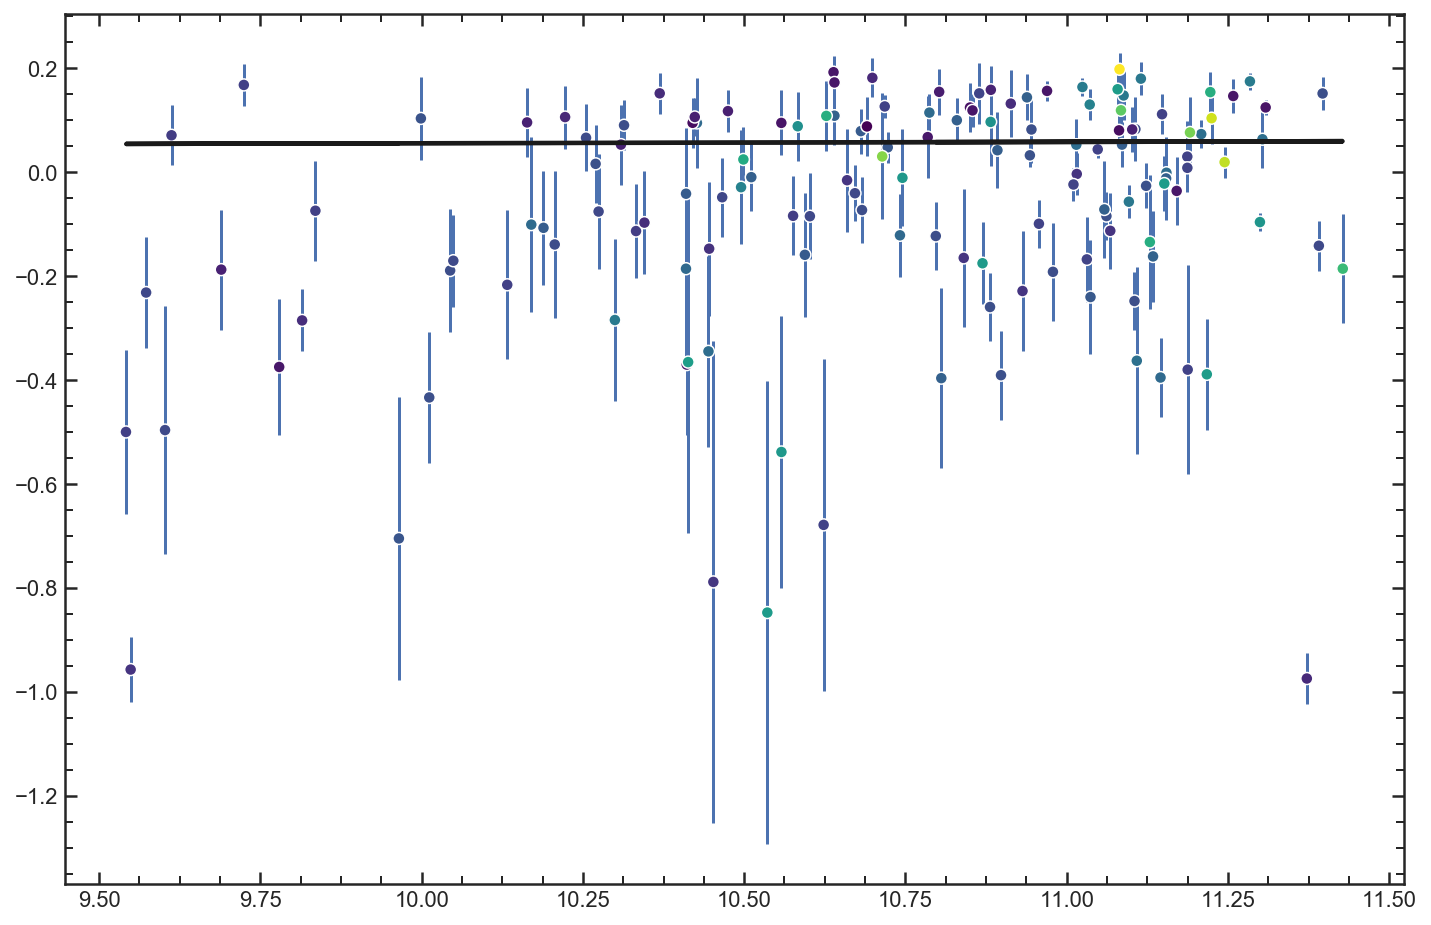

In [95]:
fig = plt.figure(figsize=[12,8])
ax = plt.subplot()
sea.scatterplot(lm, Z, hue=morph_db.zgrism,
                     palette='viridis', sizes=(10, 200),legend=False, ax=ax, zorder =2)
plt.errorbar(lm, Z, yerr = Zerr, linestyle = 'none', zorder=1)

ax.plot(lm, np.percentile(ln_grid,50, axis = 0), 'k', linewidth = 2)
ax.plot(lm, np.percentile(ln_grid,16, axis = 0), 'k', linewidth = 1)
ax.plot(lm, np.percentile(ln_grid,84, axis = 0), 'k', linewidth = 1)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-1.31, 0.5)

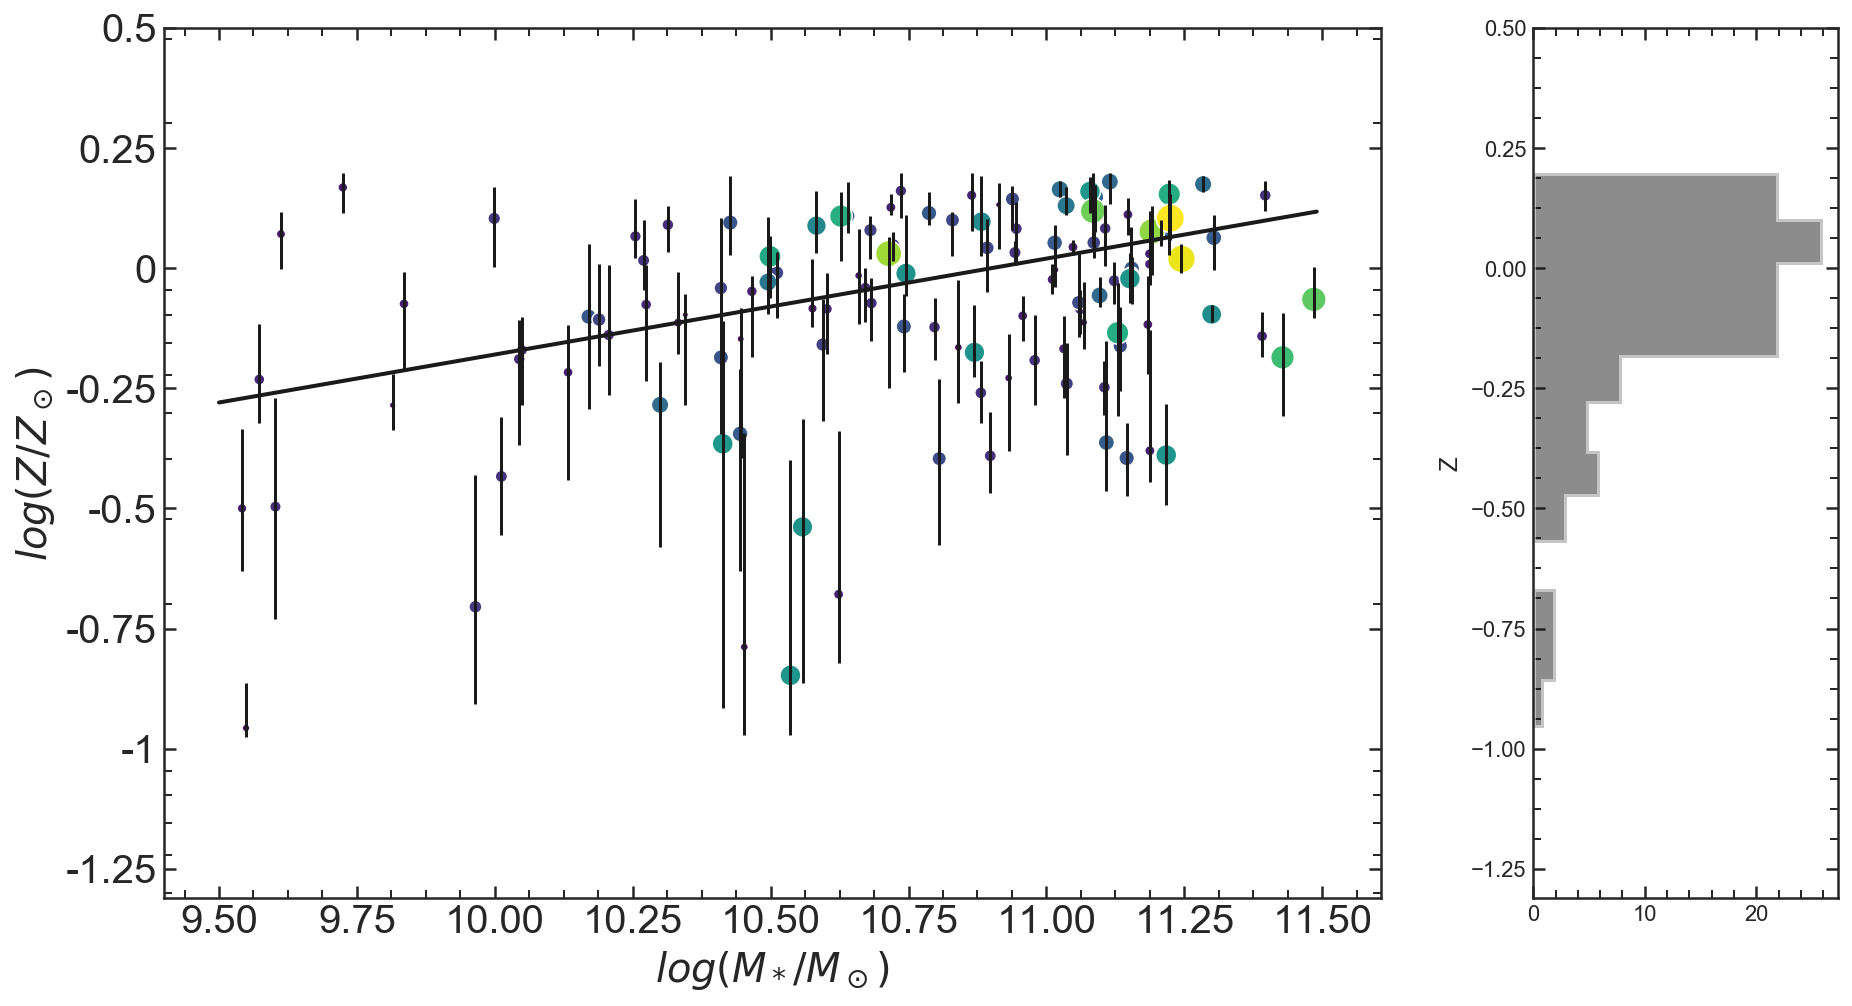

In [25]:
gs= GridSpec(1,2,width_ratios=[4,1])

fig = plt.figure(figsize=[15,8])
ax = plt.subplot(gs[0])

rl = []
rh = []
fz = []
lm = []
for i in tfits.index:
    for ii in range(len(tfits.Z_hci[i])//2):
        if tfits.Z_hci[i][2*ii] <= tfits.Z[i] <= tfits.Z_hci[i][2*ii+1]:
            ax.errorbar(tfits.lmass[i],tfits.Z[i], 
                 yerr=[[tfits.Z[i] - tfits.Z_hci[i][2*ii]], [tfits.Z_hci[i][2*ii+1] - tfits.Z[i]]], fmt='k', markersize=0)
            rl.append(tfits.Z[i] - tfits.Z_hci[i][2*ii])
            rh.append(tfits.Z_hci[i][2*ii+1] - tfits.Z[i])
            fz.append(tfits.Z[i])
            lm.append(tfits.lmass[i])
ax.set_ylim(10**-1.31,10**.5)

sea.scatterplot(lm, fz,hue=zg, size=zg,
                     palette='viridis', sizes=(10, 200),legend=False, ax=ax)


rl = np.array(rl)
rh = np.array(rh)
fz = np.array(fz)
       
errs = ((rl - rh)/2) / (fz*np.log(10))
samp = np.arange(9.5,11.5,.01)
lfit,lfit_errs,cov = Linear_fit(lm, np.log10(fz) , errs, samp, return_cov=True)

plt.plot(samp,10**lfit,'k',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,10**(lfit - lfit_errs),10**(lfit + lfit_errs),alpha = .2,label = '68% Conifidence Interval')

plt.yscale('log')
plt.yticks(10**np.array([-1.25,-1,-0.75,-.5,-.25,0,0.25,0.5]),[-1.25,-1,-0.75,-.5,-.25,0,0.25,0.5])



plt.xlabel('$log(M_*/M_\odot)$', fontsize=20)
plt.ylabel('$log(Z/Z_\odot)$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.subplot(gs[1])
sea.distplot(np.log10(tfits.Z),
             vertical=True,kde=False,hist_kws={"histtype": "stepfilled", "linewidth": 3,"alpha": 0.5,"color":'k'})
plt.ylim(-1.31,.5)

# plt.savefig('../plots/new_MM.png' ,bbox_inches = 'tight')

(0, 8)

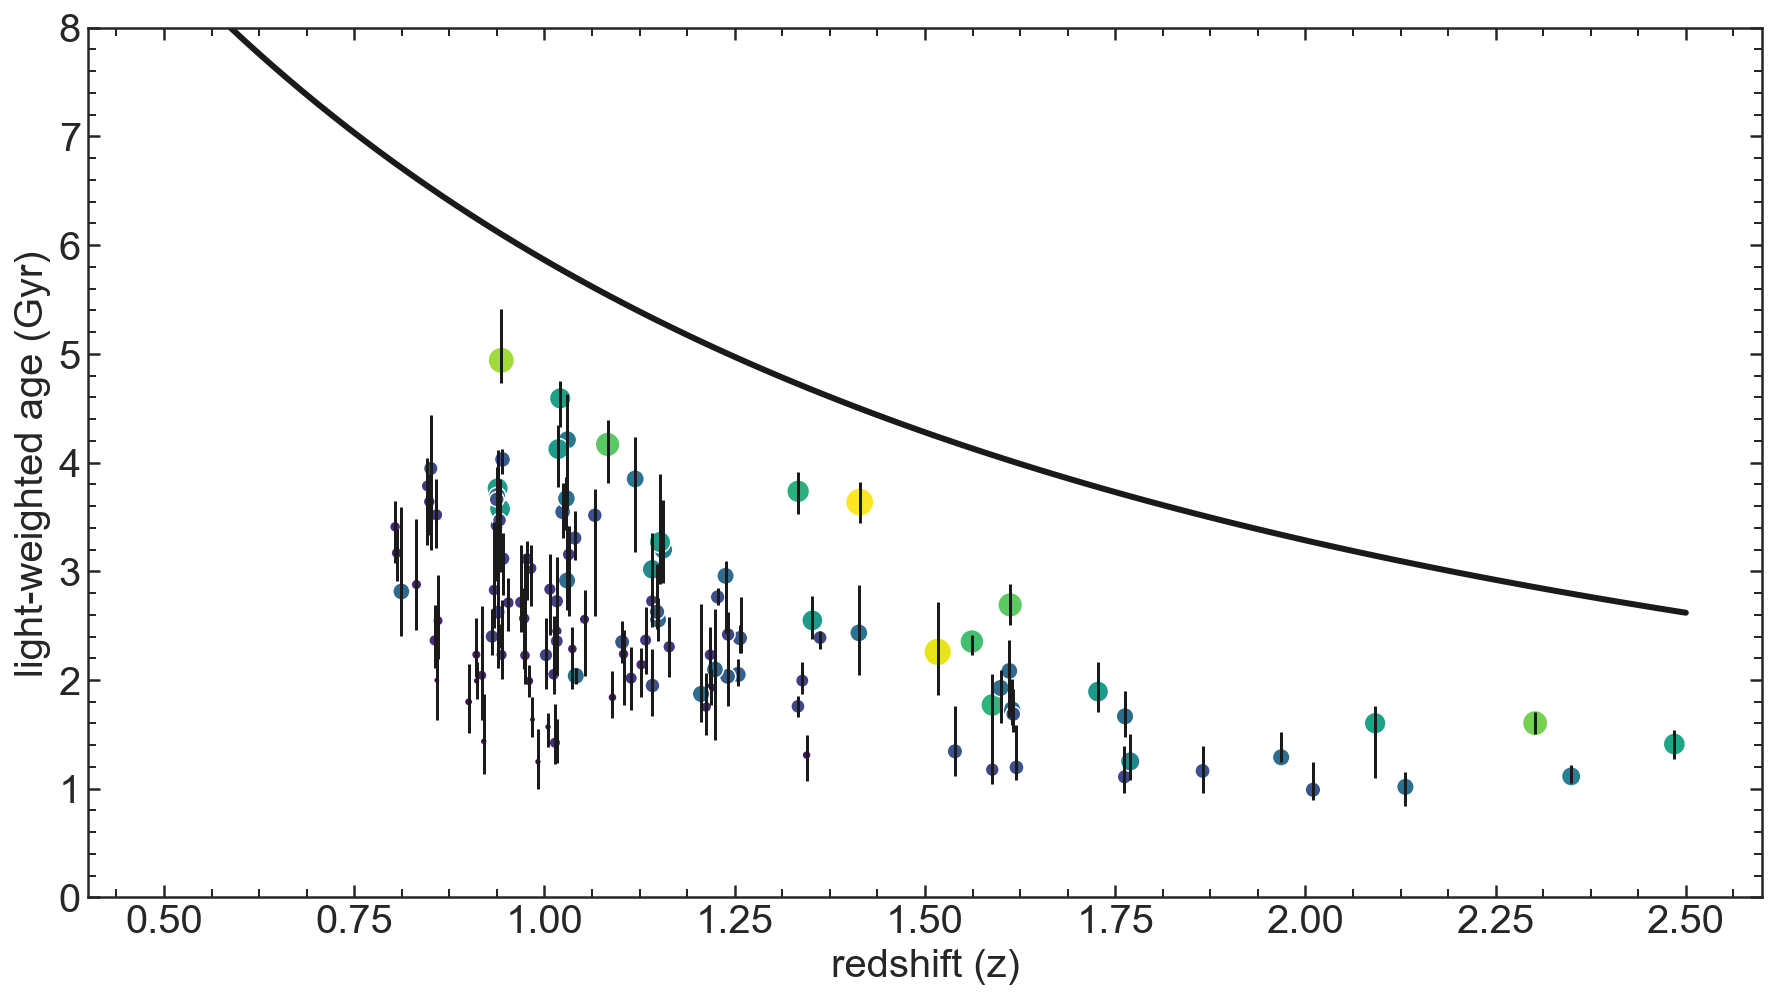

In [33]:
z=np.linspace(0.5,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

fig = plt.figure(figsize=[15,8])
ax = plt.subplot()
ax.plot(z,ages, 'k', linewidth = 3)

for i in tfits.index:
    for ii in range(len(tfits.lwa_hci[i])//2):
        if tfits.lwa_hci[i][2*ii] <= tfits.lwa[i] <= tfits.lwa_hci[i][2*ii+1]:
            ax.errorbar(tfits.zgrism[i],tfits.lwa[i], 
                 yerr=[[tfits.lwa[i] - tfits.lwa_hci[i][2*ii]], [tfits.lwa_hci[i][2*ii+1] - tfits.lwa[i]]], 
                        color='k', markersize=0)

sea.scatterplot(tfits.zgrism,tfits.lwa,hue=tfits.z_50, size=tfits.z_50,
                     palette='viridis', sizes=(10, 200),legend=False, ax=ax)

plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(0,8)
# plt.savefig('../plots/new_lwa.png' ,bbox_inches = 'tight')


In [ ]:
# sea.barplot()

(-1, 167)

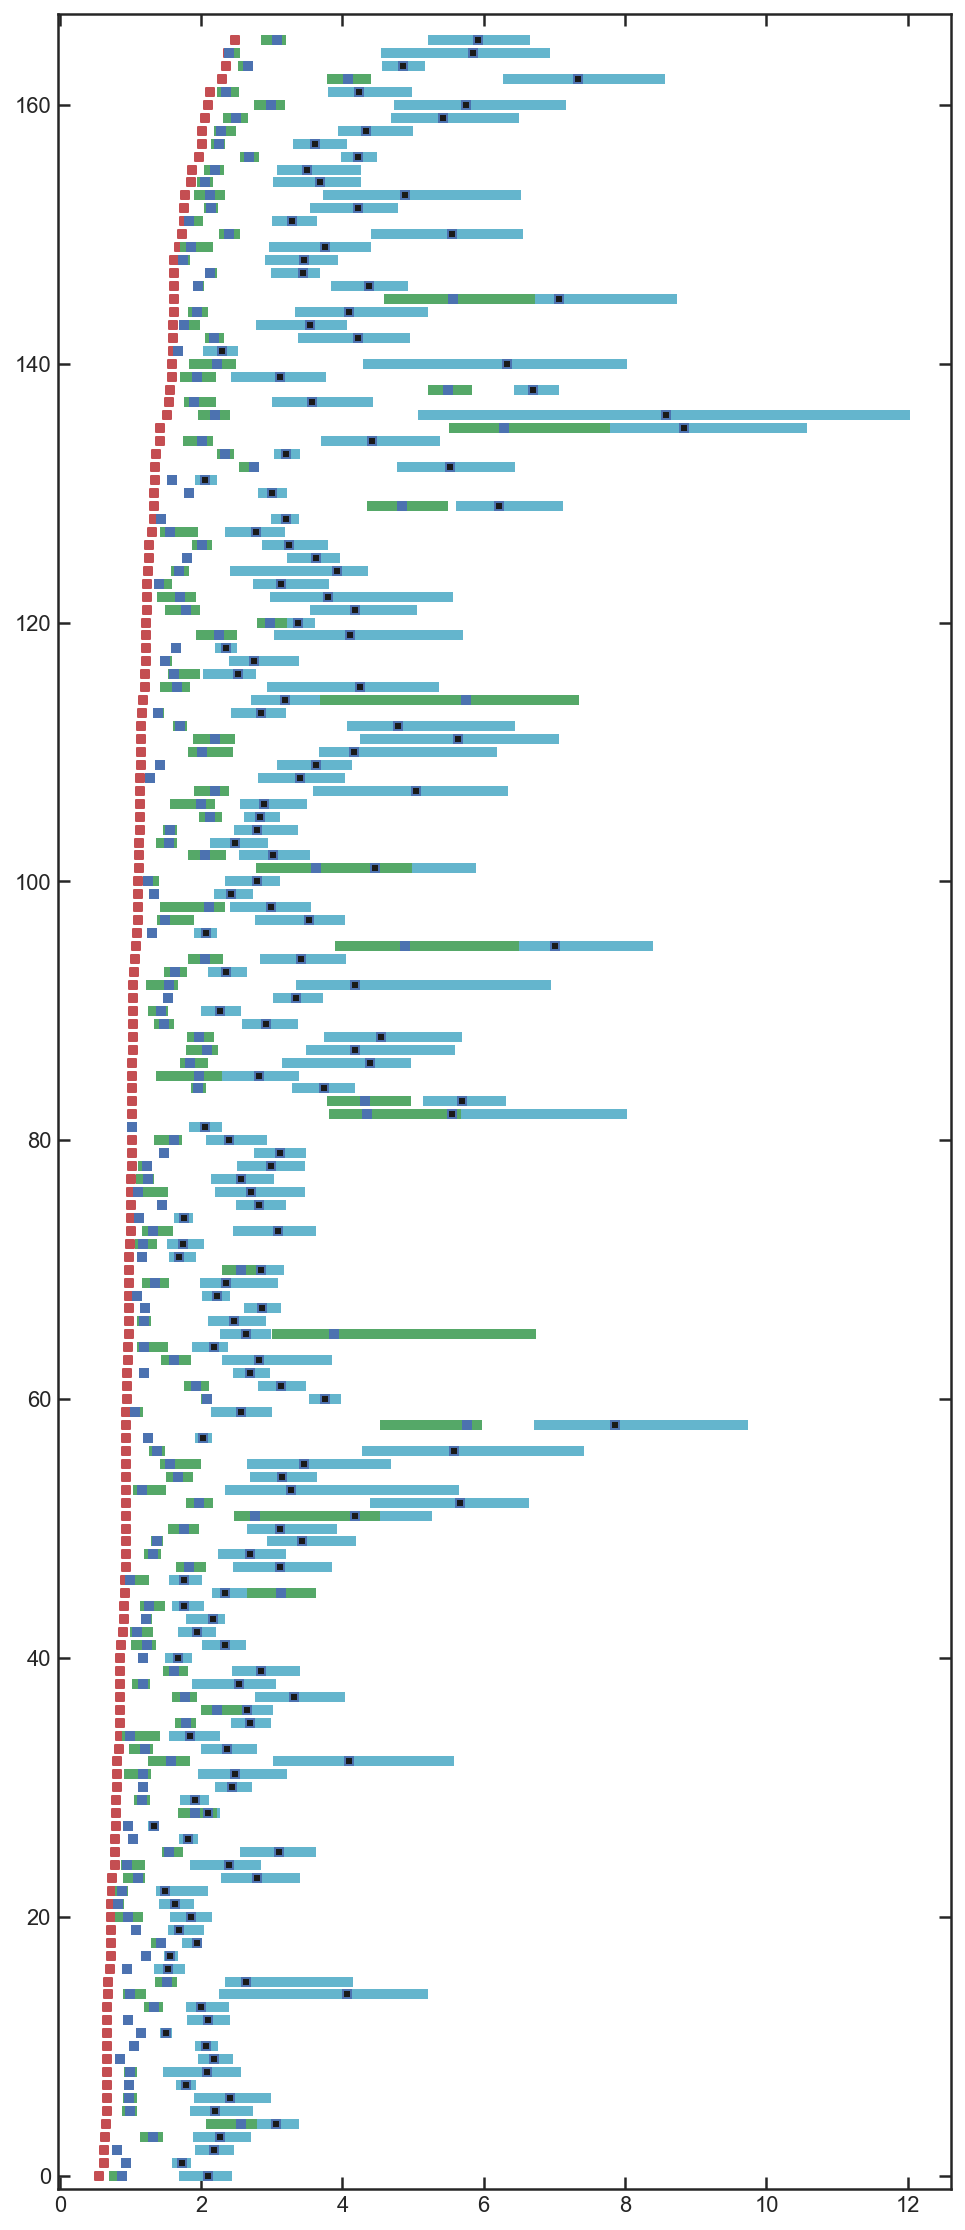

In [9]:
idx = 0
plt.figure(figsize=[8,20])
for i in tfits.sort_values('zgrism').index:
    for ii in range(len(tfits.z_50_hci[i])//2):
        if tfits.z_50_hci[i][2*ii] <= tfits.z_50[i] <= tfits.z_50_hci[i][2*ii+1]:
            plt.errorbar(tfits.z_50[i],[idx], xerr=[[tfits.z_50[i] - tfits.z_50_hci[i][2*ii]], 
                        [tfits.z_50_hci[i][2*ii+1] - tfits.z_50[i]]],marker = 's', mfc= 'k', elinewidth = 5, ecolor = 'c', markersize=4)

    for ii in range(len(tfits.z_q_hci[i])//2):
        if tfits.z_q_hci[i][2*ii] <= tfits.z_q[i] <= tfits.z_q_hci[i][2*ii+1]:
            plt.errorbar(tfits.z_q[i],[idx], xerr=[[tfits.z_q[i] - tfits.z_q_hci[i][2*ii]], 
                        [tfits.z_q_hci[i][2*ii+1] - tfits.z_q[i]]], marker = 's', mfc= 'b', elinewidth = 5, ecolor = 'g', markersize=4)
    plt.scatter(tfits.zgrism[i],[idx], marker = 's', color = 'r', s=15)
    
    idx += 1
plt.ylim(-1,167)

# Create goodness dataframe

In [46]:
flist = glob('../data/posteriors/*tabfit_Pz*')

fld = [os.path.basename(U).split('_')[0] for U in flist] 
ids = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(int)

In [2]:
GNdb = pd.read_pickle('../dataframes/galaxy_frames/GN_new.pkl')
GSdb = pd.read_pickle('../dataframes/galaxy_frames/GS_new.pkl')

In [8]:
GNdb['field'] = np.repeat('GND',len(GNdb))
GSdb['field'] = np.repeat('GSD',len(GSdb))

In [11]:
GNdb = GNdb.query('AGN != "AGN"')
GSdb = GSdb.query('AGN != "AGN"')

In [12]:
ALLdb = pd.concat([GNdb,GSdb])

In [16]:
USE = np.repeat(True, len(ALLdb))
Bllim = np.repeat(0, len(ALLdb))
Bhlim = np.repeat(1E10, len(ALLdb))
Rllim = np.repeat(0, len(ALLdb))
Rhlim = np.repeat(1E10, len(ALLdb))

In [25]:
fld = ALLdb.field.values
ids = ALLdb.id.values

In [26]:
len(fld)

118

In [413]:
ALLdb.query('id == 42548')

,dec,id,ra,zphot,AGN,new,field
72,-27.712366,42548,53.149467,1.422201,---,new,GSD


In [477]:
idx = 118

##################################################
#############Use criteria###################
field=fld[idx]
galaxy = ids[idx]

use_blim = None
use_rlim = None

USE[idx] = False

if use_blim != None:
    Bllim[idx] = use_blim[0]
    Bhlim[idx] = use_blim[1]
else:
    Bllim[idx] = 0
    Bhlim[idx] = 1E10

    
if use_rlim != None:
    Rllim[idx] = use_rlim[0]
    Rhlim[idx] = use_rlim[1]
else:
    Rllim[idx] = 0
    Rhlim[idx] = 1E10

#############################################
#############################################    

if USE[idx]:

#     m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, bsc, rsc, bp1, \
#     rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
#         '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))

    Gs = Gen_spec(field, galaxy, 1, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
        phot_errterm = 0.04, irac_err = 0.08, decontam = False, 
        Bselect = [Bllim[idx], Bhlim[idx]], Rselect = [Rllim[idx], Rhlim[idx]],auto_select = False ) 

#     sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
#     sp.params['dust2'] = d
#     sp.params['dust1'] = d
#     sp.params['logzsol'] = np.log10(m)

#     time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

#     sp.set_tabular_sfh(time,sfr)    

#     wave, flux = sp.get_spectrum(tage = a, peraa = True)    

#     Gs.Sim_all_premade(wave*(1+z),flux)

    # if Gs.g102 and Gs.g141:
    #     bcal, rcal = Calibrate_grism(Gs, [Gs.Bmfl,Gs.Rmfl], [bp1,rp1], [Gs.Bwv,Gs.Rwv], [Gs.Bfl,Gs.Rfl], [Gs.Ber,Gs.Rer])

#     if Gs.g102:
#     #     bcal = Calibrate_grism(Gs, [Gs.Bmfl], [bp1], [Gs.Bwv], [Gs.Bfl], [Gs.Ber])[0]
#         bcal = Calibrate_grism([Gs.Bwv,Gs.Bfl,Gs.Ber], Gs.Bmfl, bp1)[0]

#     if Gs.g141:
#     #     rcal = Calibrate_grism(Gs, [Gs.Rmfl], [rp1], [Gs.Rwv], [Gs.Rfl], [Gs.Rer])[0]
#         rcal = Calibrate_grism([Gs.Rwv,Gs.Rfl,Gs.Rer], Gs.Rmfl, rp1)[0]
    bcal = 1
    rcal = 1
    
    plt.figure(figsize=[12,8])
    ###############plot tab##################

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv),Gs.Bfl*1E18 / bcal,Gs.Ber*1E18 / bcal,
                linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 2)
#         plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl*1E18,'k', zorder = 4)

    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv),Gs.Rfl*1E18 /  rcal,Gs.Rer*1E18 / rcal,
                linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
#         plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl*1E18,'k', zorder = 4)

    plt.errorbar(np.log10(Gs.Pwv),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='p', markersize=15, color='#984ea3', zorder = 1)
#     plt.plot(np.log10(Gs.Pwv_rf),Gs.Pmfl*1E18,'ko', zorder = 3)
    plt.xticks(np.log10([5000,7500,10000,25000]),[5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel('Wavelength ($\AA$)', fontsize=20)
    plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)


IndexError: index 118 is out of bounds for axis 0 with size 118

In [478]:
selec_db = pd.DataFrame({'field':fld,'id':ids,'use':USE,'bllim':Bllim,'bhlim':Bhlim,'rllim':Rllim,'rhlim':Rhlim})

In [479]:
selec_db.to_pickle('../spec_files/new_section.pkl')

<ErrorbarContainer object of 3 artists>

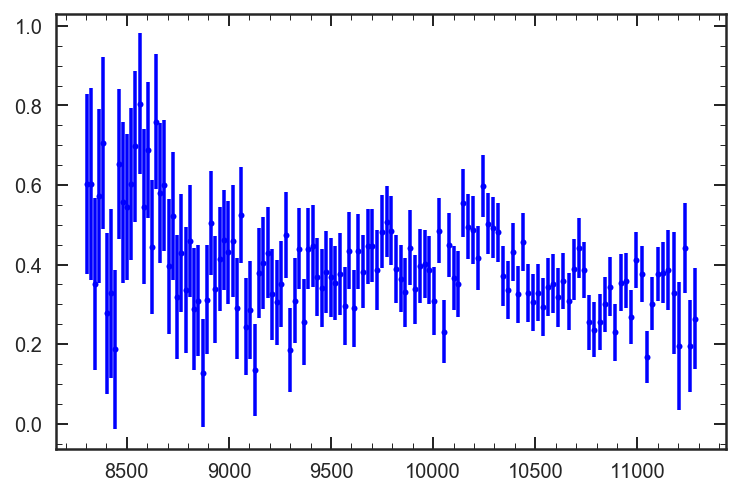

In [472]:
plt.errorbar(Gs.Bwv,Gs.Bfl*1E18, Gs.Ber*1E18,
            linestyle='None', marker='o', markersize=3, color='b', zorder = 2)
# plt.axvline(8700)
# plt.axvline(5176)

<ErrorbarContainer object of 3 artists>

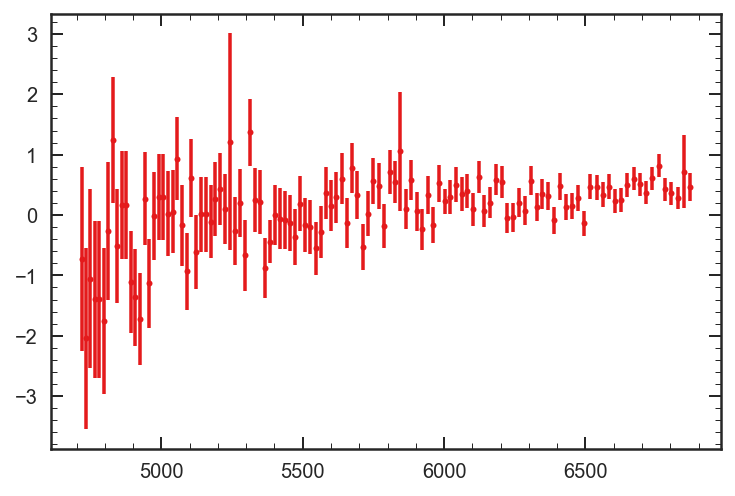

In [475]:
plt.errorbar(Gs.Rwv/2.4 ,Gs.Rfl*1E18, Gs.Rer*1E18,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
# plt.axvline(14000)

In [482]:
old_select = pd.read_pickle('../spec_files/section.pkl')
new_select = pd.read_pickle('../spec_files/new_section.pkl')

In [486]:
new_select['AGN'] = np.repeat('---', len(new_select))

In [498]:
zs = []

for i in new_select.index:
    if new_select.field[i] == 'GND':
        zs.append(GNdb.query('id == {0}'.format(new_select.id[i])).zphot.values[0])
    if new_select.field[i] == 'GSD':
        zs.append(GSdb.query('id == {0}'.format(new_select.id[i])).zphot.values[0])

In [500]:
new_select['zphot'] = zs

In [505]:
all_select = pd.concat([old_select,new_select], ignore_index=True)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [527]:
all_select.to_pickle('../spec_files/all_section.pkl')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


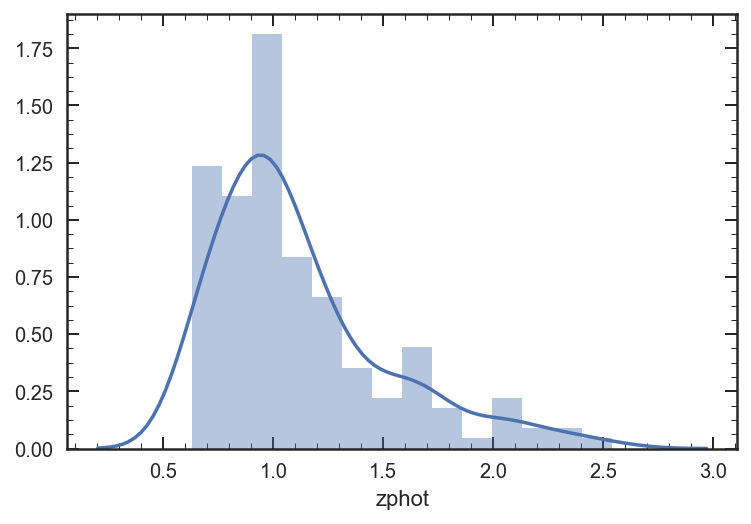

In [508]:
sea.distplot(all_select.query('AGN != "AGN" and use == True').zphot)

In [522]:
allzgrizli = []
for idx in all_select.index:
    if all_select.field[idx][1] == 'N':
        pre = 'N'
    else:
        pre = 'S'

    gid = all_select.id[idx]

    fp = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format(pre, gid))

    subfields = [U.split('/')[-2] for U in fp]

    zgrizli = []

    for sb in subfields:
        dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(sb)), format='fits').to_pandas()

        zgrizli.append(dat.query('ID == {0}'.format(gid)).z_50.values[0])
        
    allzgrizli.append(zgrizli)

In [524]:
all_select['zgrizli'] = allzgrizli

In [2]:
all_select = pd.read_pickle('../spec_files/all_section.pkl')

In [14]:
def Plot_contam(field, galaxy, zgriz,savefig = False):
    try:
        m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
        bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
            '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
        best = True
        z= [z]
    except:
        z=zgriz
        best = False

    for xx in range(len(z)):

        Gs = Gen_spec(field, galaxy, z[xx], g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.04, irac_err = 0.08, decontam = False) 

        if best:
            sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
            sp.params['dust2'] = d
            sp.params['dust1'] = d
            sp.params['logzsol'] = np.log10(m)

            time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

            sp.set_tabular_sfh(time,sfr)    

            wave, flux = sp.get_spectrum(tage = a, peraa = True)    
            Gs.Best_fit_scale(wave, flux, z[xx], bp1, rp1, sp.stellar_mass, lm)


        plt.figure(figsize=[16,5])
        ###############plot tab##################

        if Gs.g102:
            IDCB = decontam_reg(Gs.Bwv, Gs.Ber, Gs.Bline, Gs.Bcont)
            plt.errorbar(Gs.Bwv_rf, Gs.Bfl *1E18, Gs.Ber *1E18,
                    linestyle='None', marker='o', markersize=3, color='#377eb8', zorder = 1)
            plt.errorbar(Gs.Bwv_rf[IDCB], Gs.Bfl[IDCB] *1E18, Gs.Ber[IDCB] *1E18,
                    linestyle='None', marker='o', markersize=3, color='k', zorder = 2)

        if Gs.g141:
            IDCR = decontam_reg(Gs.Rwv, Gs.Rer, Gs.Rline, Gs.Rcont)
            plt.errorbar(Gs.Rwv_rf,Gs.Rfl *1E18,Gs.Rer *1E18,
                    linestyle='None', marker='o', markersize=3, color='#e41a1c', zorder = 2)
            plt.errorbar(Gs.Rwv_rf[IDCR],Gs.Rfl[IDCR] *1E18,Gs.Rer[IDCR] *1E18,
                    linestyle='None', marker='o', markersize=3, color='k', zorder = 2)


        plt.axvline(3727.092,linestyle='--', alpha=.3)
        plt.axvline(4102.89,linestyle='--', alpha=.3, color = 'r')
        plt.axvline(4341.68,linestyle='--', alpha=.3, color = 'r')
        plt.axvline(4862.68,linestyle='--', alpha=.3, color = 'r')
        plt.axvline(5008.240,linestyle='--', alpha=.3)
        plt.axvline(6564.61,linestyle='--', alpha=.3, color = 'r')
        plt.axvline(6718.29,linestyle='--', alpha=.3, color = 'k')

        plt.title(field + str(galaxy), fontsize=25)
        plt.xlabel('Wavelength ($\AA$)', fontsize=20)
        plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=20)
        plt.tick_params(axis='both', which='major', labelsize=15)

        if savefig:
            plt.savefig('../plots/contam/{0}_{1}_{2:1.4f}.png'.format(field, galaxy,z[xx]),bbox_inches = 'tight')

In [3]:
def decontam_reg(W, E, L, C):
    IDC = []
        
    for i in range(len(W)):
        if (C[i] + E[i]) > L[i]:
            IDC.append(i)

    return IDC

In [16]:
# for i in all_select.index:
#     Plot_contam(all_select.field[i], all_select.id[i], all_select.zgrizli[i], savefig=True)

In [ ]:
os.path.isfile()

# create mask

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


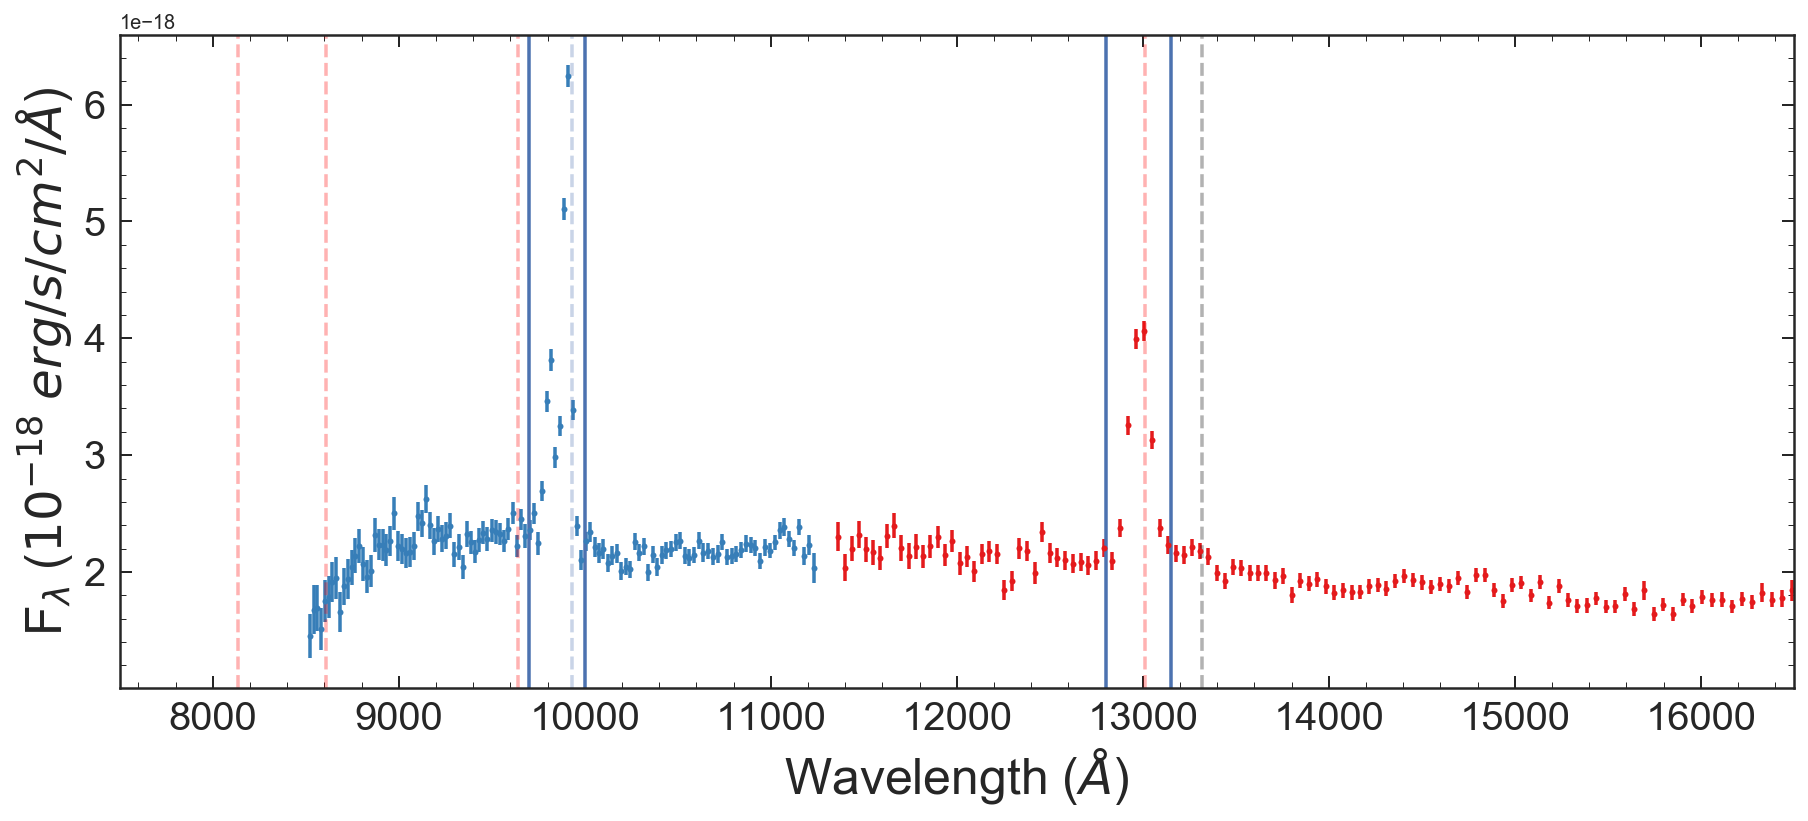

In [102]:
field = 'GSD'
galaxy = 45789

try:
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    best = True
    rshift = z
except:
    print(all_select.query('id == {0}'.format(galaxy)).zgrizli.values)
    rshift = all_select.query('id == {0}'.format(galaxy)).zgrizli.values[0][0]
    
    best = False
# rshift = 1.15
Gs = Gen_spec(field, galaxy, 1, g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
    phot_errterm = 0.04, irac_err = 0.08, decontam = False,auto_select = True ) 

plt.figure(figsize = [15,6])
plt.errorbar(Gs.Bwv,Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(Gs.Rwv,Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')

plt.axvline(3727.092 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.29 * (1 + rshift),linestyle='--', alpha=.3, color = 'k')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(7500,16500)

plt.axvline(9700)
plt.axvline(10000)
plt.axvline(12800)
plt.axvline(13150)

mask = [[9700,10000],[12800,13150]]

IDMB = np.repeat(True, len(Gs.Bwv))
IDMR = np.repeat(True, len(Gs.Rwv))

for m in mask:
    for i in range(len(Gs.Bwv)):
        if m[0] < Gs.Bwv[i] < m[1]:
            IDMB[i] = False
    for i in range(len(Gs.Rwv)):
        if m[0] < Gs.Rwv[i] < m[1]:
            IDMR[i] = False
            
np.save('../spec_files/mask/{0}_{1}_mask'.format(field, galaxy), mask)

In [36]:
all_select.query('id == 36348')

,AGN,bhlim,bllim,field,id,rhlim,rllim,use,zphot,zgrizli
38,---,1.000000e+10,0,GND,36348,1.000000e+10,0,True,0.976412,[0.6378039709435321]


In [37]:
rshift

1.0088835976916184

(7500, 16500)

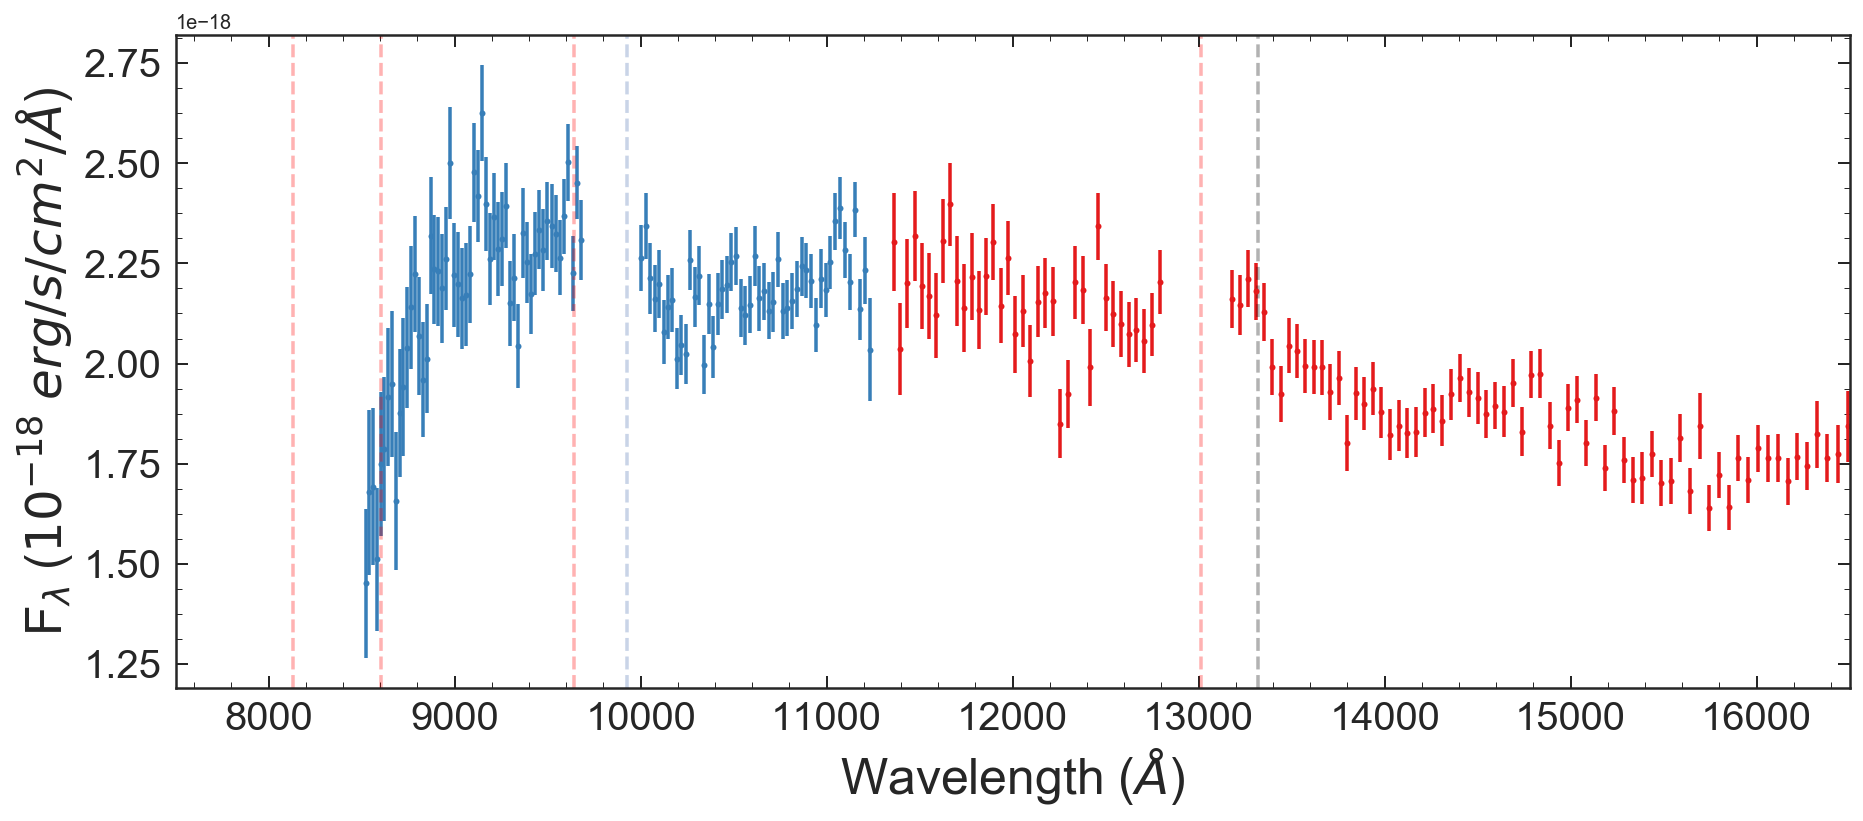

In [103]:
plt.figure(figsize = [15,6])
plt.errorbar(Gs.Bwv[IDMB],Gs.Bfl[IDMB],Gs.Ber[IDMB],
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(Gs.Rwv[IDMR],Gs.Rfl[IDMR],Gs.Rer[IDMR],
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')



plt.axvline(3727.092 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.29 * (1 + rshift),linestyle='--', alpha=.3, color = 'k')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(7500,16500)

[list([0.8607475852314306])]


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


(7500, 16500)

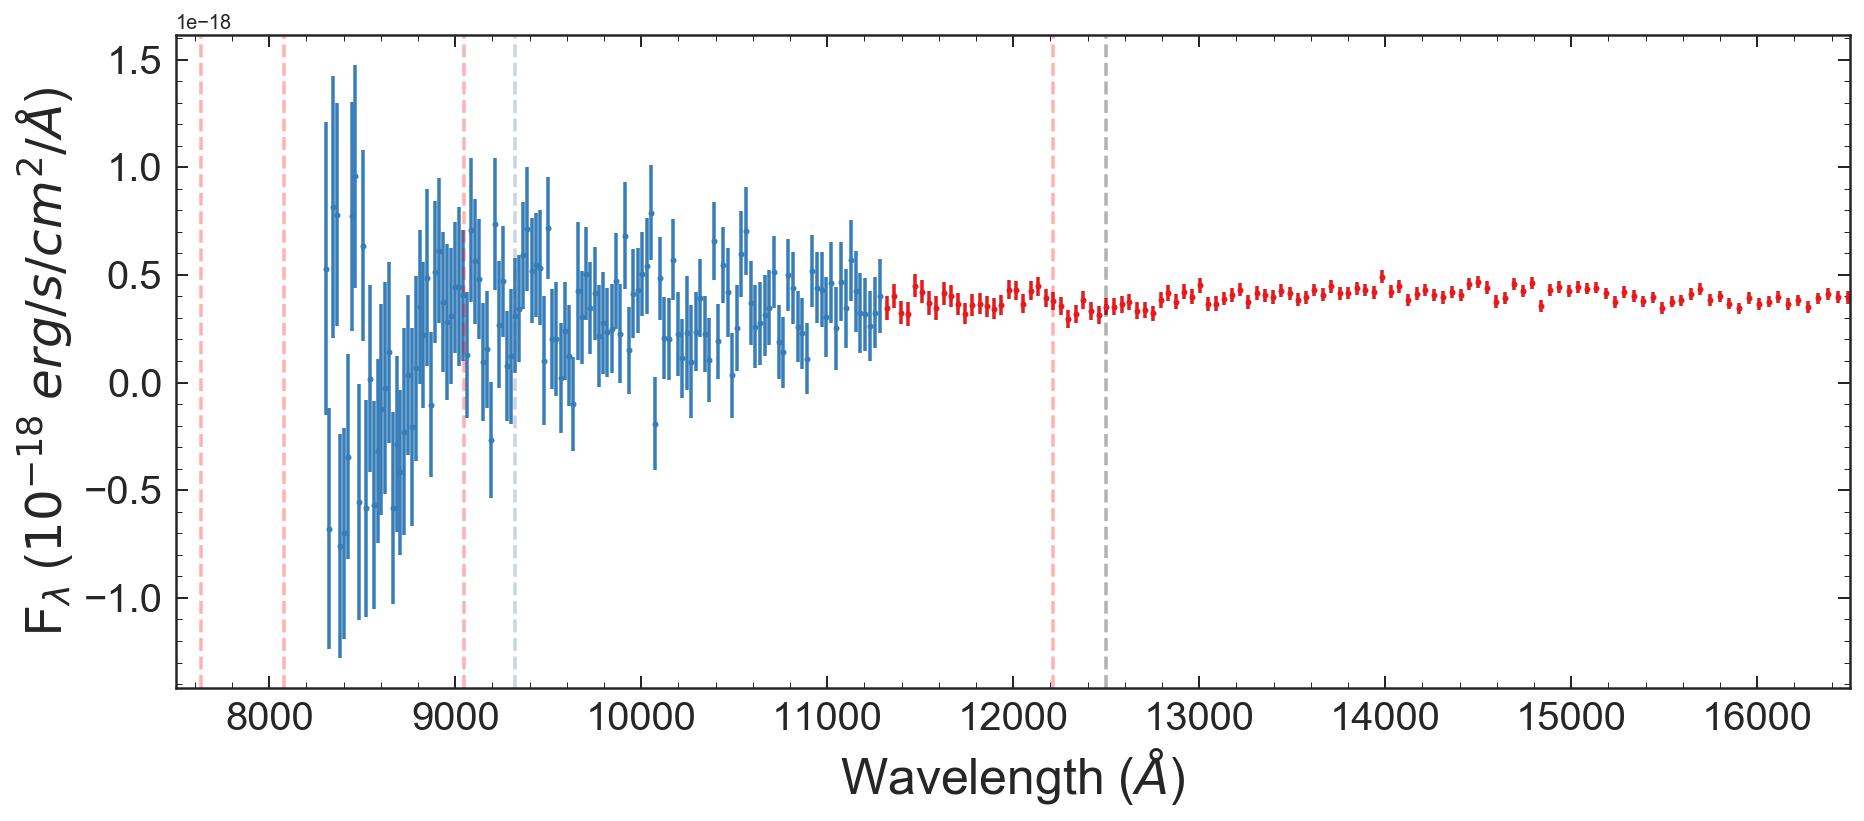

In [37]:
field = 'GND'
galaxy = 19442

try:
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))
    best = True
    rshift = z
except:
    print(all_select.query('id == {0}'.format(galaxy)).zgrizli.values)
    rshift = all_select.query('id == {0}'.format(galaxy)).zgrizli.values[0][0]
    
    best = False
Gs = Gen_spec(field, galaxy, 1, g102_lims=[8300, 11288], g141_lims=[11288, 16500],
    phot_errterm = 0.04, irac_err = 0.08) 

plt.figure(figsize = [15,6])
if Gs.g102:
    plt.errorbar(Gs.Bwv,Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
if Gs.g141:
    plt.errorbar(Gs.Rwv,Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')

plt.axvline(3727.092 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(4102.89 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(5008.240 * (1 + rshift),linestyle='--', alpha=.3)
plt.axvline(6564.61 * (1 + rshift),linestyle='--', alpha=.3, color = 'r')
plt.axvline(6718.29 * (1 + rshift),linestyle='--', alpha=.3, color = 'k')

plt.xlabel('Wavelength ($\AA$)', fontsize=25)
plt.ylabel('F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/\AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(7500,16500)


In [47]:
glob(beam_path + '*{0}*g102*'.format(19442))

['../beams/o326.0_19442.g102.A.fits']

In [ ]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0,  sfh = 4, tau = 0.6, dust_type = 1)

model_wave, model_flux = sp.get_spectrum(tage = 3.6, peraa = True)

### set beams
BEAMS = []
TRANS = []

for i in beam:
    Beam = model.BeamCutout(fits_file = i)

    W, F = forward_model_grism(Beam, model_wave, np.ones(len(model_wave)))
    trans = interp1d(W,F)(wv)       

    BEAMS.append(Beam)
    TRANS.append(trans)

return BEAMS, TRANS

GND 17746
GND 19442
GND 20567
GND 21724
GND 22027
GND 22358
GND 22774
GND 32146
GND 32566
GND 32691
GND 32933
GND 33093
GSD 30566
GSD 30587
GSD 45128
GSD 46066
0


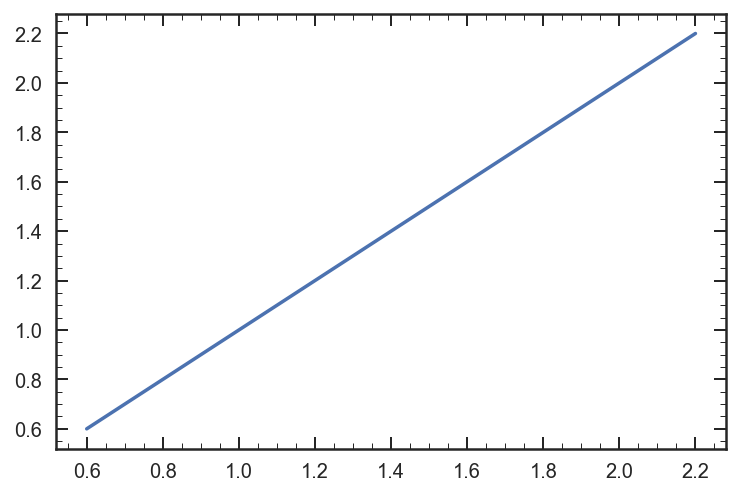

In [36]:
gselect = all_select.query('AGN != "AGN" and use == True')

u = 0
for i in gselect.index:
    try:
        x,px = np.load('../data/posteriors/{0}_{1}_zfit_Pz.npy'.format(gselect.field[i], gselect.id[i]))
#         if x[px == max(px)] < 0.7:
#             plt.plot(x,px)
#             u+=1
    except:
        print(gselect.field[i], gselect.id[i])
        
plt.plot([0.6,2.2],[0.6,2.2]) 
print(u)

In [13]:
len(glob('../data/posteriors/*zfit_bfit*'))

161

In [18]:
len(glob('../cluster_scripts/*zfit*'))

166

In [28]:
166 - 16 - 14

136

In [28]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

In [29]:
def IMG_pull(field, galaxy, smin = -0.1, smax = 0.3):
    if field[1] == 'S':
        seg = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_seg.fits')[0].data
        f160 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F160W_orig_sci.fits')[0].data
        f125 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss_3dhst.v4.0.F125W_orig_sci.fits')[0].data
        f105 = fits.open('/Volumes/Vince_CLEAR/gsd_img/goodss-F105W-astrodrizzle-v4.4_drz_sci.fits')[0].data

    if field[1] == 'N':
        seg = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_seg.fits')[0].data
        f160 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].data
        f125 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn_3dhst.v4.0.F125W_orig_sci.fits')[0].data
        f105 = fits.open('/Volumes/Vince_CLEAR/gnd_img/goodsn-F105W-astrodrizzle-v4.4_drz_sci.fits')[0].data
        
    ###############img plot################
    idx = np.argwhere(seg == galaxy)

    ylist = np.arange(min(idx.T[0]), max(idx.T[0]) + 1, 1)
    xlist = np.arange(min(idx.T[1]), max(idx.T[1]) + 1, 1)

    segimg = seg[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f105img = f105[min(idx.T[0]): max(idx.T[0]), min(idx.T[1]): max(idx.T[1])]
    f105img[segimg != galaxy] = 0
    maxloc = np.argwhere(f105img == np.max(f105img))[0]

    ycnt = ylist[maxloc[0]]
    xcnt = xlist[maxloc[1]]

    f105img = f105[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]
    f125img = f125[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]
    f160img = f160[ycnt - 40: ycnt + 41, xcnt - 40: xcnt + 41]

    img = np.zeros((f125img.shape[0], f125img.shape[1], 3), dtype=float)
    img[:,:,0] = img_scale.asinh(f160img, scale_min = smin, scale_max = smax)
    img[:,:,1] = img_scale.asinh(f125img, scale_min = smin, scale_max = smax)
    img[:,:,2] = img_scale.asinh(f105img, scale_min = smin, scale_max = smax)
    return img

In [30]:
def plot_posterior(field, galaxy, param, name, x_name, y_name, roundto = 3):
    grow = morph_db.query('id == {0}'.format(galaxy))
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, param))
    ipz = interp1d(np.round(z,roundto),pz)

    plt.plot(z,pz,'k')
    for i in range(len(grow['{0}_hci'.format(name)].values[0])//2):
        hdr = np.linspace(np.round(grow['{0}_hci'.format(name)].values[0][2*i],roundto),
                          np.round(grow['{0}_hci'.format(name)].values[0][2*i+1],roundto))
        plt.fill_between(hdr, ipz(hdr), color = '#4E7577', alpha=0.75)
    plt.vlines(grow['{0}'.format(name)].values[0],0, ipz(np.round(grow['{0}'.format(name)].values[0],roundto)), color = '#C1253C')
    plt.xlabel('{0}'.format(x_name), fontsize=15)
    plt.ylabel('P({0})'.format(y_name), fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0,max(pz)*1.05)
    if max(pz) >= 3:
        plt.yticks(np.linspace(0,max(pz)*1.05,4).astype(int))

def PLOT(field, galaxy, savefig = False):
    grow = morph_db.query('id == {0}'.format(galaxy))

    Gs = Gen_spec(field, galaxy, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
    Flam = Posterior_spec(field, galaxy)
    
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field, galaxy))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field, galaxy))
    rp1 = x[px == max(px)][0]
    
    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    sfh = Rescale_sfh(field, galaxy)

    gs = GridSpec(3,5, hspace=0.3, wspace = 0.35)   

    plt.figure(figsize=[19,15])
    ###############plot tab##################
    plt.subplot(gs[0,:3])

    if Gs.g102:
        plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
        plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]
        
    if Gs.g141:
        plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
        plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1)

    plt.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 1, label = 'Model', zorder=5)
    plt.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 1)
    plt.xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))

    plt.xticks(np.log10([2500,5000,7500,10000,25000]),[2500,5000,7500,10000,25000])
    plt.title(galaxy, fontsize=25)
    plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=20)
    plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

    ###############sfh plot################
    isfhl = interp1d(sfh.LBT,sfh.SFH_16)
    isfhh = interp1d(sfh.LBT,sfh.SFH_84)

    ax1 = plt.subplot(gs[0,3:5])
    ax2 = ax1.twiny()

    ax1.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
    ax1.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
    ax1.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
    ax1.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
    ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
    ax2.xaxis.set_ticks_position('top')

    ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
    ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
    ax2.set_xlabel('Redshift (z)', fontsize=15) 
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=15)

    ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
    ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

    for i in range(len(grow.t_50_hci.values[0])//2):
        hdr = np.linspace(grow.t_50_hci.values[0][2*i],grow.t_50_hci.values[0][2*i+1])

        ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
        ax1.vlines(grow.t_50_hci.values[0][2*i],isfhl(grow.t_50_hci.values[0][2*i]),isfhh(grow.t_50_hci.values[0][2*i]), 
                   color = 'k', linewidth = 1, zorder = 8)
        ax1.vlines(grow.t_50_hci.values[0][2*i+1],isfhl(grow.t_50_hci.values[0][2*i+1]),isfhh(grow.t_50_hci.values[0][2*i+1]), 
                   color = 'k', linewidth = 1, zorder = 8)

    ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = '#4E7577', linewidth = 2, zorder = 11)
    ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = 'k', linewidth = 4, zorder = 10)

    for i in range(len(grow.t_q_hci.values[0])//2):
        hdr = np.linspace(grow.t_q_hci.values[0][2*i],grow.t_q_hci.values[0][2*i+1])

        ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = 'k', alpha=0.6, zorder = 8)
        ax1.vlines(grow.t_q_hci.values[0][2*i],isfhl(grow.t_q_hci.values[0][2*i]),isfhh(grow.t_q_hci.values[0][2*i]), 
                   color = 'k', linewidth = 1, zorder = 8)
        ax1.vlines(grow.t_q_hci.values[0][2*i+1],isfhl(grow.t_q_hci.values[0][2*i+1]),isfhh(grow.t_q_hci.values[0][2*i+1]), 
                   color = 'k', linewidth = 1, zorder = 8)
    
    ###############plot zoom tab##################
    plt.subplot(gs[1,:3])

    if Gs.g102:
        plt.errorbar(Gs.Bwv_rf,Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
        plt.plot(Gs.Bwv_rf,Gs.Bmfl *1E18,'k', zorder = 4)
        
    if Gs.g141:
        plt.errorbar(Gs.Rwv_rf,Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
        plt.plot(Gs.Rwv_rf,Gs.Rmfl *1E18,'k', zorder = 4)

    plt.xlabel(r'Wavelength ($\rm  \AA$)', fontsize=20)
    plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
        
    #################plot image###################
    img = IMG_pull(field, galaxy)
    
    plt.subplot(gs[1,3:5])
    plt.imshow(img,aspect='equal')
    plt.title('Blue = F105W, Green = F125W, Red = F160W', fontsize = 15)
    plt.xticks([])
    plt.yticks([])

    ###############P(Z)################
    plt.subplot(gs[2,0])
    plot_posterior(field, galaxy, 'm', 'Z', 'Z / Z$_\odot$', 'Z / Z$_\odot$')
    
    ###############P(lwa)################
    plt.subplot(gs[2,1])
    plot_posterior(field, galaxy, 'lwa', 'lwa', 'LWA (Gyr)', 'LWA')
 
    ###############P(z)################
    plt.subplot(gs[2,2])
    plot_posterior(field, galaxy, 'z', 'zgrism', 'Redshift (z)', 'z', roundto=4)
    
    ###############P(d)################
    plt.subplot(gs[2,3])
    plot_posterior(field, galaxy, 'd', 'Av', 'Dust (Av)', 'Av')
    
    ###############P(lmass)################
    plt.subplot(gs[2,4])
    plot_posterior(field, galaxy, 'lm', 'lmass', 'log(M/M$_\odot$)', 'log(M/M$_\odot$)')
    
    if savefig:
        plt.savefig('../plots/fullfits/all_data_{0}_{1}.png'.format(field, galaxy),bbox_inches = 'tight')

In [32]:
morph_db.query('z_q > z_50')[['field','id']]

,field,id
98,GND,22463
106,GND,24953
128,GSD,25799


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


img_scale : asinh
img_scale : asinh
img_scale : asinh


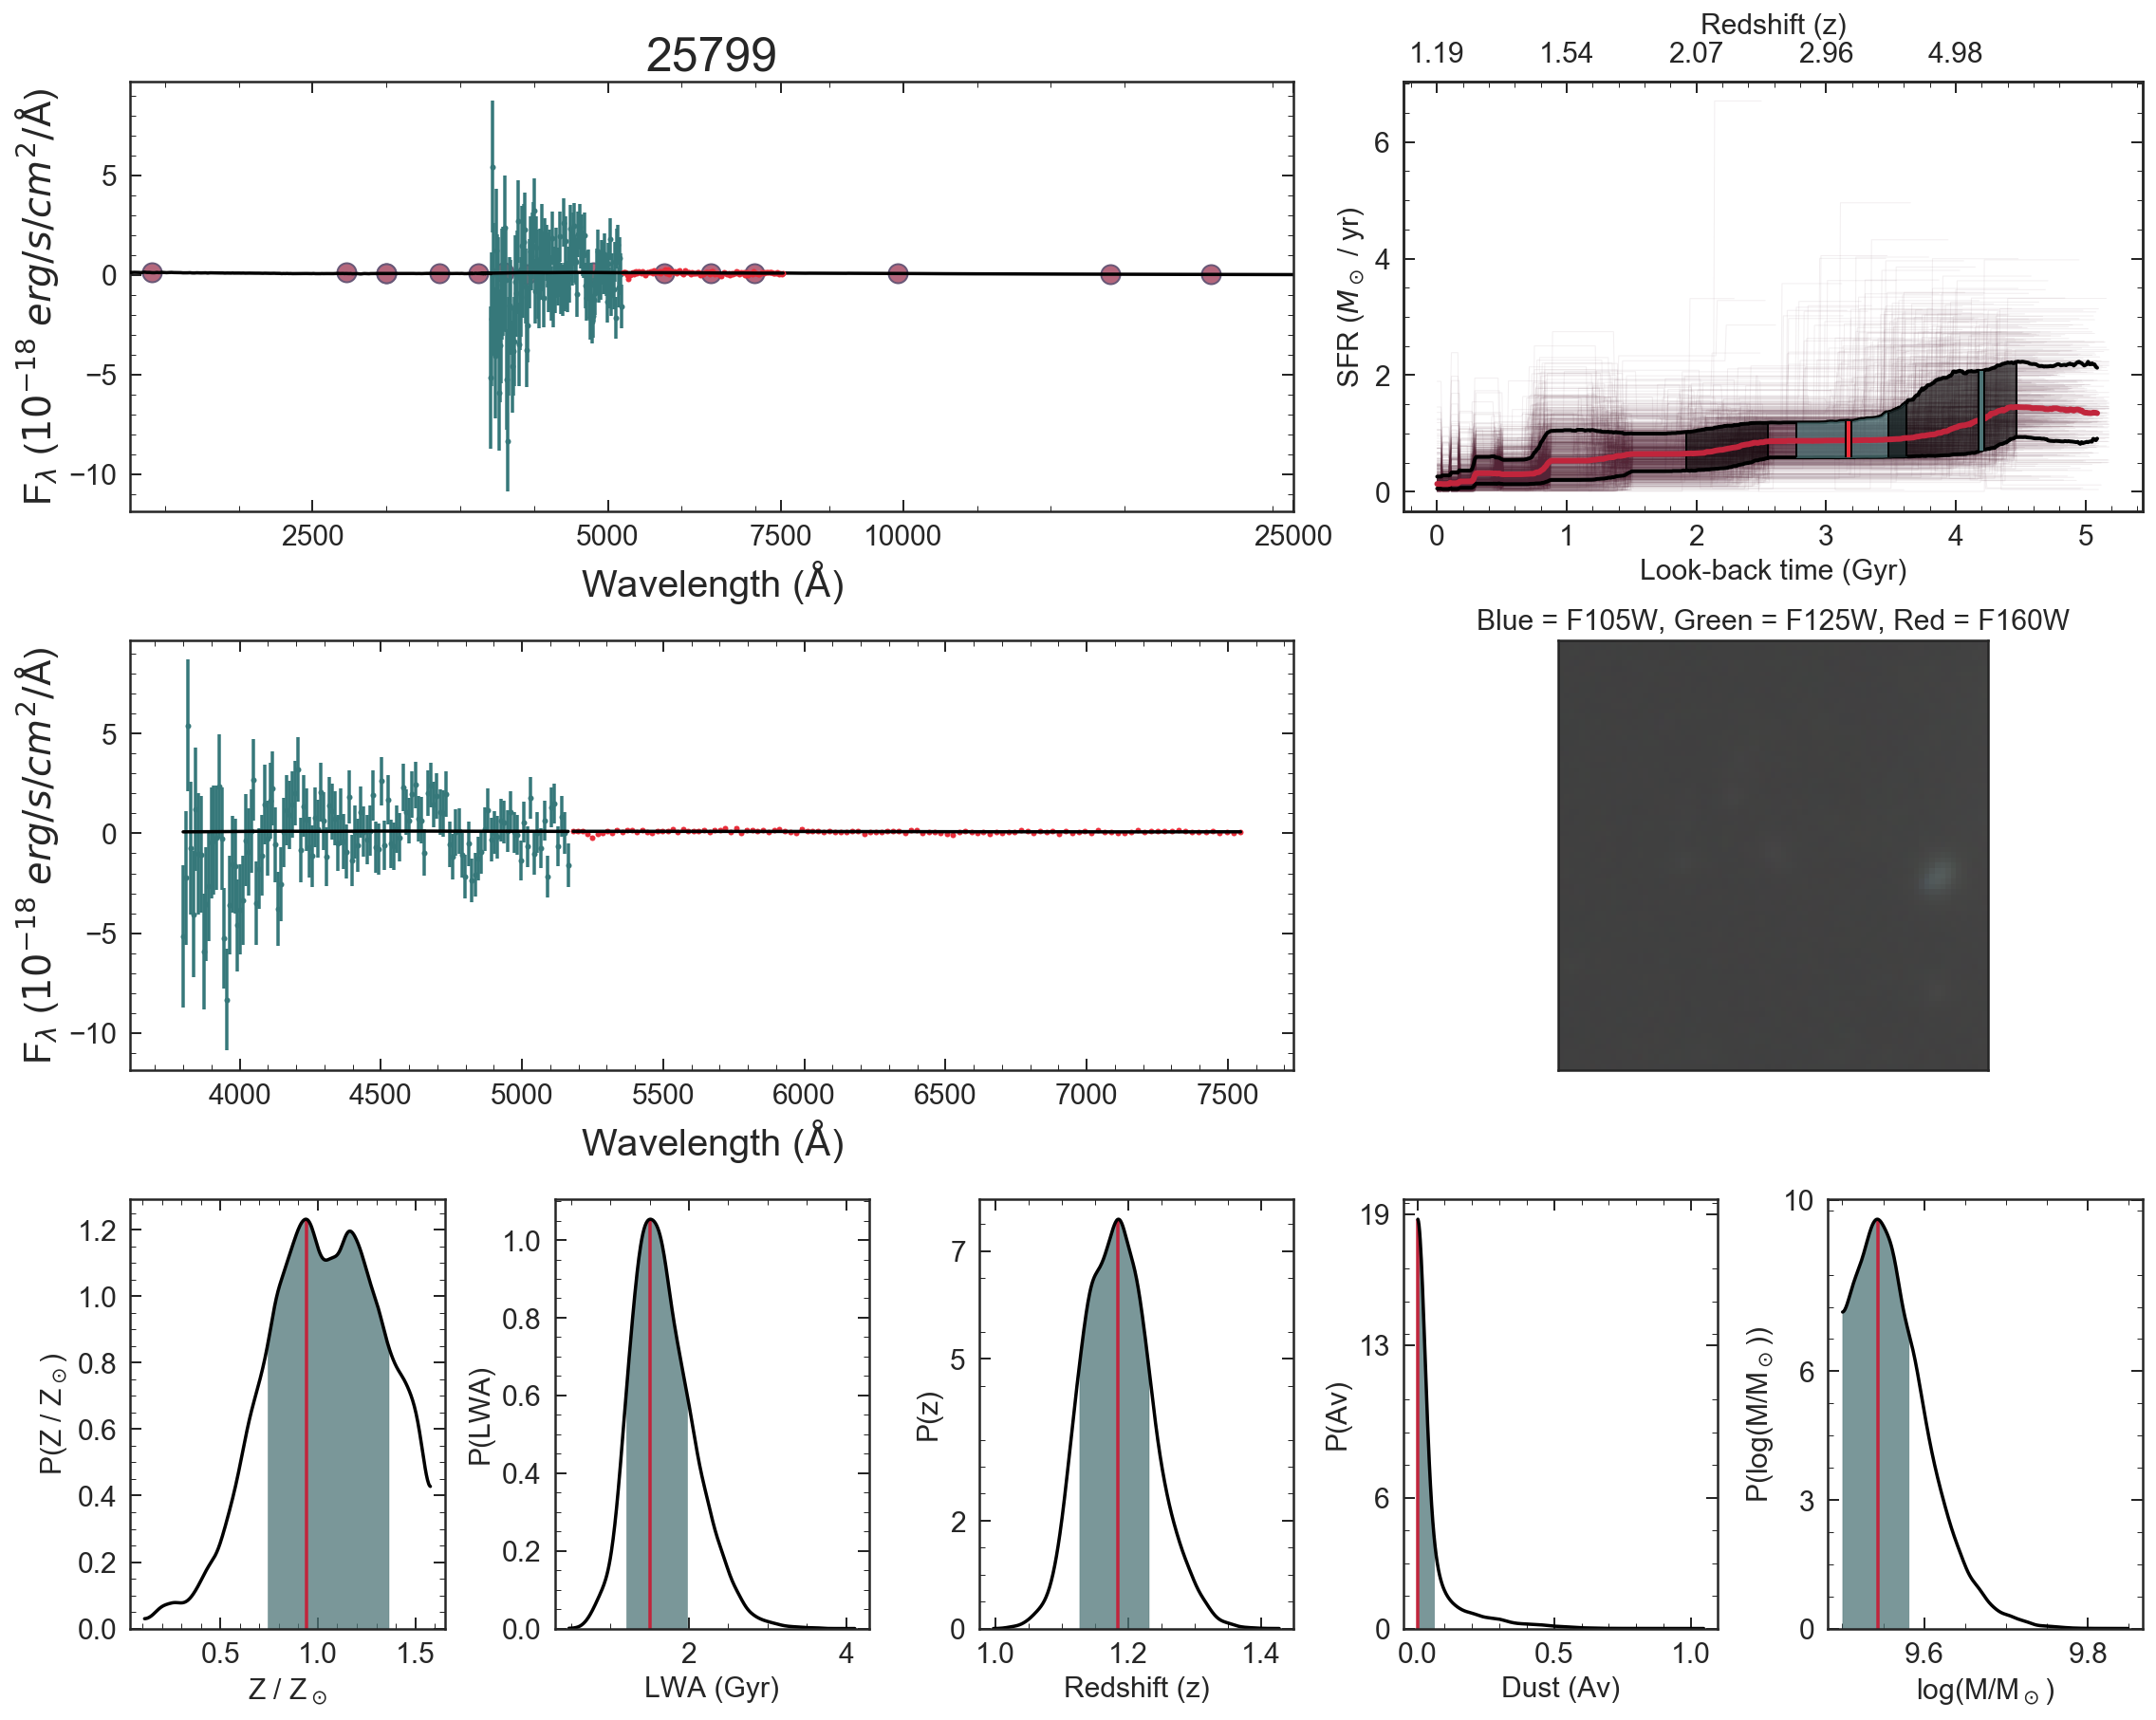

In [36]:
PLOT('GSD', 25799)

m Z Z / Z$_\odot$ Z / Z$_\odot$


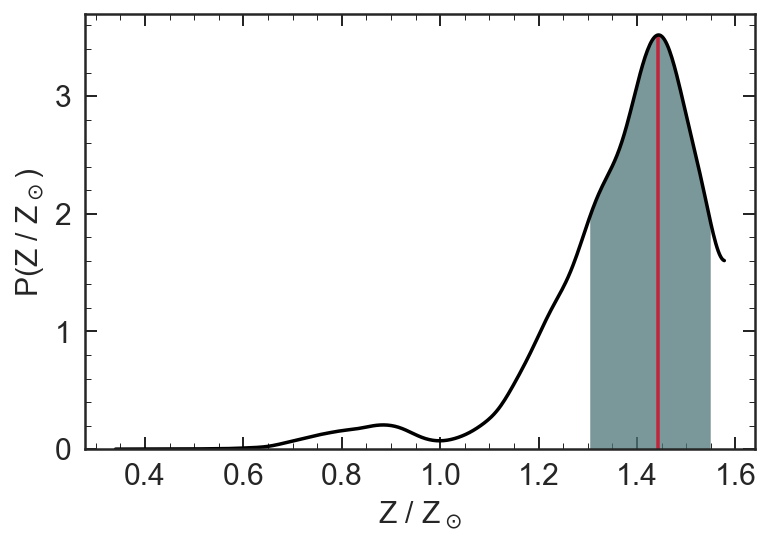

In [108]:
def plot_posterior(field, galaxy, param, name, x_name, y_name, roundto = 3):
    grow = morph_db.query('id == {0}'.format(galaxy))
    z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, param))
    ipz = interp1d(np.round(z,roundto),pz)

    plt.plot(z,pz,'k')
    for i in range(len(grow['{0}_hci'.format(name)].values[0])//2):
        hdr = np.linspace(np.round(grow['{0}_hci'.format(name)].values[0][2*i],roundto),
                          np.round(grow['{0}_hci'.format(name)].values[0][2*i+1],roundto))
        plt.fill_between(hdr, ipz(hdr), color = '#4E7577', alpha=0.75)
    plt.vlines(grow['{0}'.format(name)].values[0],0, ipz(np.round(grow['{0}'.format(name)].values[0],roundto)), color = '#C1253C')
    plt.xlabel('{0}'.format(x_name), fontsize=15)
    plt.ylabel('P({0})'.format(y_name), fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0,max(pz)*1.05)
    if max(pz) >= 3:
        plt.yticks(np.linspace(0,max(pz)*1.05,4).astype(int))

field = 'GSD'
galaxy=41520


###############P(Z)################
# plt.subplot(gs[2,0])
plot_posterior(field, galaxy, 'm', 'Z', 'Z / Z$_\odot$', 'Z / Z$_\odot$')

# ###############P(lwa)################
# plt.subplot(gs[2,1])
# plot_posterior(field, galaxy, 'lwa', 'lwa', 'LWA (Gyr)', 'LWA')

# ###############P(z)################
# plt.subplot(gs[2,2])
# plot_posterior(field, galaxy, 'z', 'zgrism', 'Redshift (z)', 'z', roundto=4)

# ###############P(d)################
# plt.subplot(gs[2,3])
# plot_posterior(field, galaxy, 'd', 'Av', 'Dust (Av)', 'Av')

# ###############P(lmass)################
# plt.subplot(gs[2,4])
# plot_posterior(field, galaxy, 'lm', 'lmass', 'log(M/M$_\odot$)', 'log(M/M$_\odot$)')

In [8]:
sfh = Rescale_sfh('GND', 21156)

sfh.z_50_hci

In [22]:
grow.Av_16.values[0]

0.00155

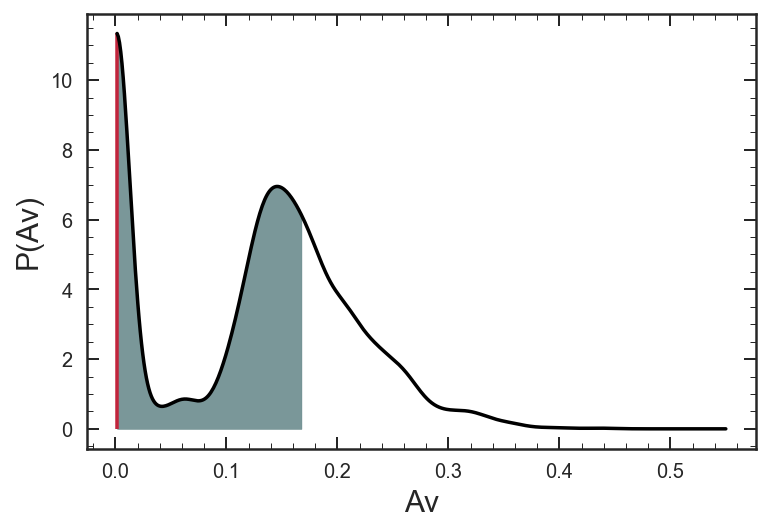

In [23]:
field = 'GND'
galaxy = 17070
grow = morph_db.query('id == 17070')

z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pd.npy'.format(field, galaxy))
ipz = interp1d(np.round(z,5),pz)
hdr = np.linspace(grow.Av_16.values[0], grow.Av_84.values[0])
plt.plot(z,pz,'k')
plt.fill_between(hdr, ipz(hdr), color = '#4E7577', alpha=0.75)
plt.vlines(grow.Av.values[0],0, ipz(grow.Av.values[0]), color = '#C1253C')
plt.xlabel('Av', fontsize=15)
plt.ylabel('P(Av)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=10)

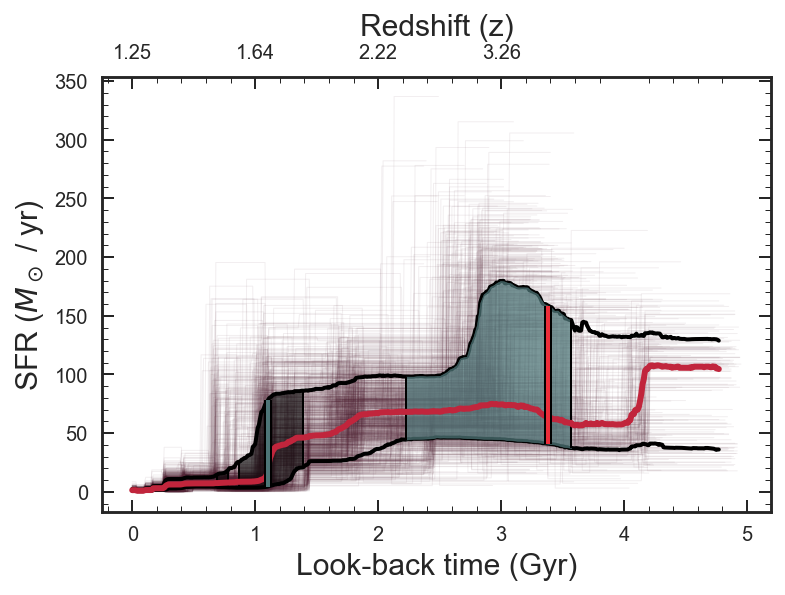

In [70]:
field ='GND'
galaxy=21156

grow = morph_db.query('id == {0}'.format(galaxy))

sfh = Rescale_sfh(field, galaxy)

isfhl = interp1d(sfh.LBT,sfh.SFH_16)
isfhh = interp1d(sfh.LBT,sfh.SFH_84)

ax1 = plt.subplot()
ax2 = ax1.twiny()

ax1.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
ax1.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax1.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
ax1.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,int(sfh.fulltimes[-1])))
ax2.set_xticklabels(np.round(lbt_to_z(np.arange(0,int(sfh.fulltimes[-1])) + cosmo.lookback_time(grow.zgrism.values[0]).value),2))
ax2.xaxis.set_ticks_position('top')

ax1.set_xlabel('Look-back time (Gyr)', fontsize=15)
ax1.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=15)
ax2.set_xlabel('Redshift (z)', fontsize=15) 
ax1.tick_params(axis='both', which='major', labelsize=10)

ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
ax1.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

for i in range(len(grow.t_50_hci.values[0])//2):
    hdr = np.linspace(grow.t_50_hci.values[0][2*i],grow.t_50_hci.values[0][2*i+1])

    ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
    ax1.vlines(grow.t_50_hci.values[0][2*i],isfhl(grow.t_50_hci.values[0][2*i]),isfhh(grow.t_50_hci.values[0][2*i]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax1.vlines(grow.t_50_hci.values[0][2*i+1],isfhl(grow.t_50_hci.values[0][2*i+1]),isfhh(grow.t_50_hci.values[0][2*i+1]), 
               color = 'k', linewidth = 1, zorder = 8)

ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = '#4E7577', linewidth = 2, zorder = 11)
ax1.vlines(grow.t_q.values[0],isfhl(grow.t_q.values[0]),isfhh(grow.t_q.values[0]), color = 'k', linewidth = 4, zorder = 10)

for i in range(len(grow.t_q_hci.values[0])//2):
    hdr = np.linspace(grow.t_q_hci.values[0][2*i],grow.t_q_hci.values[0][2*i+1])

    ax1.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = 'k', alpha=0.6, zorder = 8)
    ax1.vlines(grow.t_q_hci.values[0][2*i],isfhl(grow.t_q_hci.values[0][2*i]),isfhh(grow.t_q_hci.values[0][2*i]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax1.vlines(grow.t_q_hci.values[0][2*i+1],isfhl(grow.t_q_hci.values[0][2*i+1]),isfhh(grow.t_q_hci.values[0][2*i+1]), 
               color = 'k', linewidth = 1, zorder = 8)

In [12]:
for i in range(len(grow.t_50_hci.values[0])//2):
    print(grow.t_50_hci.values[0][2*i],grow.t_50_hci.values[0][2*i+1])

1.534165758564297 1.9506072533639123


In [10]:
len(grow.t_50_hci.values[0])


2

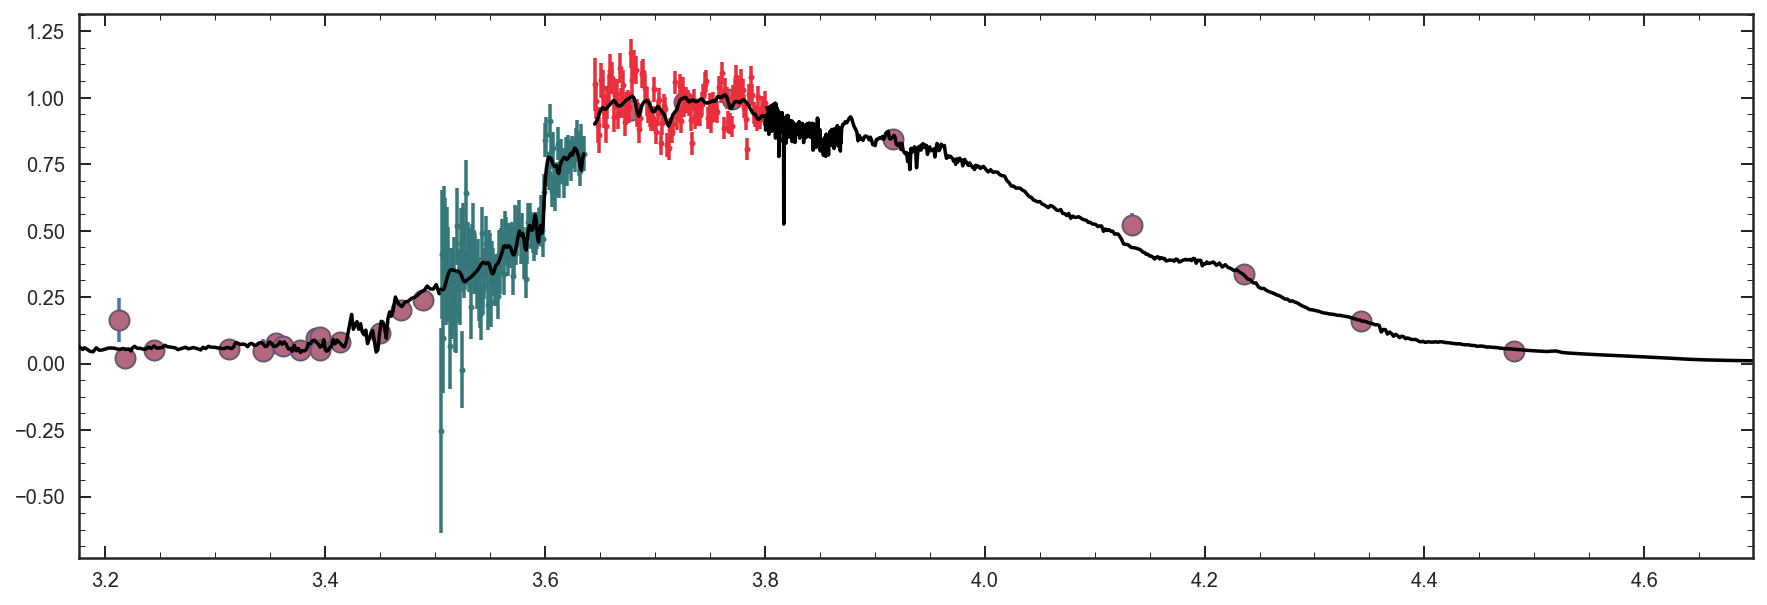

In [36]:
plt.figure(figsize=[15,5])
###############plot tab##################

if Gs.g102:
    plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
    plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)

if Gs.g141:
    plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
    plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

plt.xlim(np.log10(1500),np.log10(50000))
IDB = [U for U in range(len(wave)) if wave[U] < Gs.Bwv_rf[0]]
IDR = [U for U in range(len(wave)) if wave[U] > Gs.Rwv_rf[-1]]

plt.plot(np.log10(wave)[IDB],SPEC[IDB]*1E18,'k', alpha = 1, label = 'Model', zorder=5)
plt.plot(np.log10(wave)[IDR],SPEC[IDR]*1E18,'k', alpha = 1)

In [58]:
import pymc3

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# z,pz = np.load('../data/posteriors/GSD_41520_tabfit_Pd.npy')
# print(Highest_density_region(pz,z))
def Gen_PPF(x,px):
    return interp1d(np.cumsum(px) / np.cumsum(px).max(),x, bounds_error=False, fill_value=0)

In [73]:
av_ppf = Gen_PPF(z,pz)

In [82]:
pymc3.stats.hpd(av_ppf(np.random.rand(10000)), alpha = .32)

array([0.12680816, 0.3375816 ])

In [3]:
class Posterior_spec(object):
    def __init__(self, field, galaxy, trials = 1000):

        sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

        ppf_dict = {}
        params = ['m','a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm','d']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        self.rshift = x[px == max(px)][0]

        idx = 0

        flam_grid=[]

        while idx < trials:
#             try:
            draw = np.zeros(len(params))

            for i in range(len(draw)):
                draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

            sp.params['dust2'] = draw[13]
            sp.params['dust1'] = draw[13]
            sp.params['logzsol'] = np.log10(draw[0])

            time, sfr, tmax = convert_sfh(get_agebins(draw[1]), draw[2:12], maxage = draw[1]*1E9)

            sp.set_tabular_sfh(time,sfr)    

            self.wave, flux = sp.get_spectrum(tage = draw[1], peraa = True)   

            flam_grid.append(F_lam_per_M(flux, self.wave * (1 + self.rshift), self.rshift, 0, sp.stellar_mass)*10**draw[12])

            idx +=1
#             except:
#                 pass

        self.SPEC = np.percentile(flam_grid,50, axis = 0)
        self.SPEC_16 = np.percentile(flam_grid,16, axis = 0)
        self.SPEC_84 = np.percentile(flam_grid,84, axis = 0)

In [6]:
Flam = Posterior_spec('GSD', 39170)

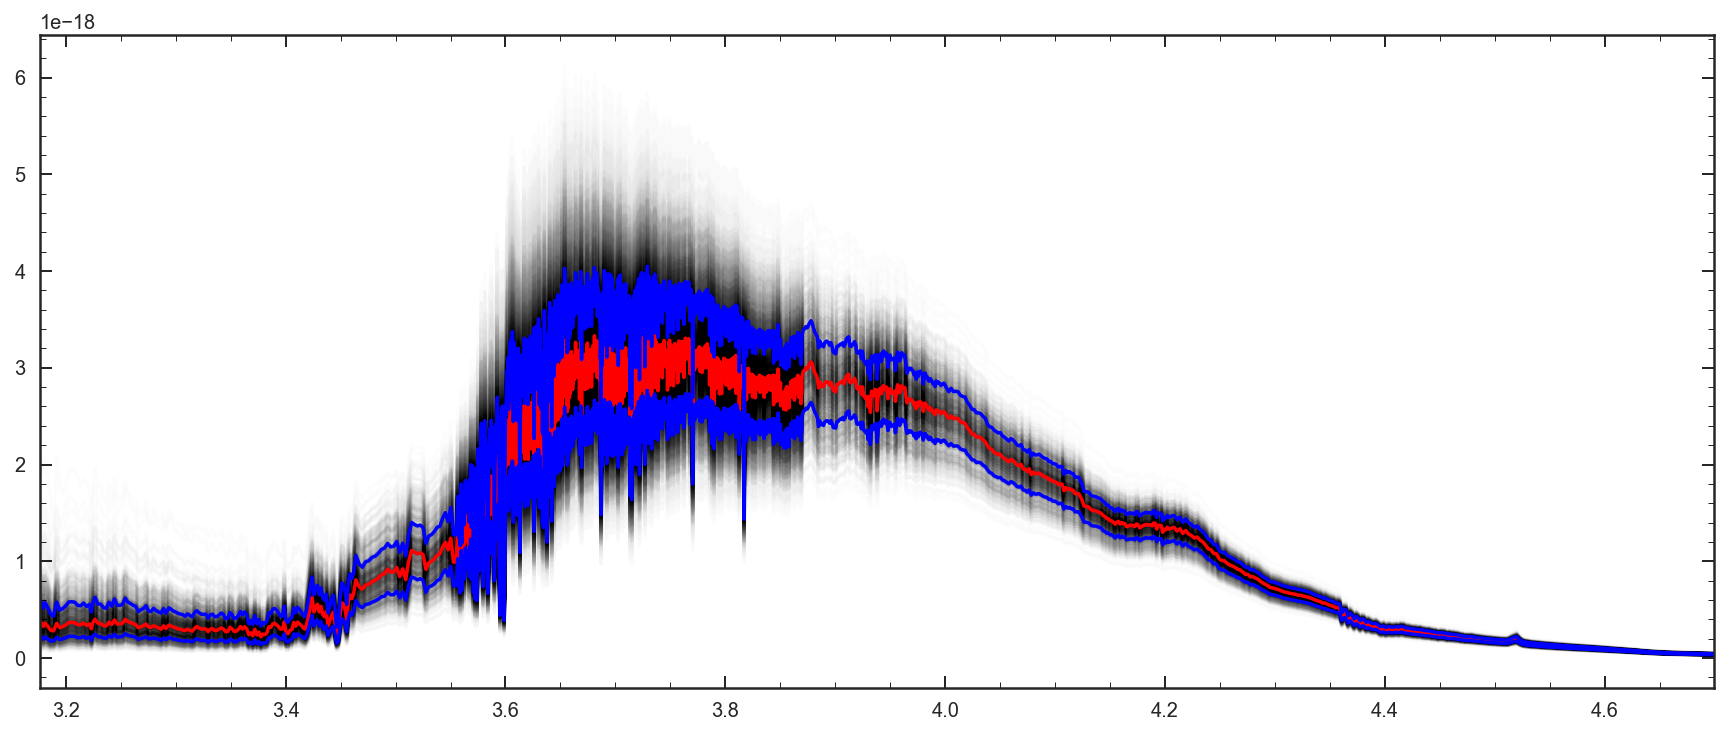

In [74]:
plt.figure(figsize=[15,6])
for spec in flam_grid:
    plt.plot(np.log10(wave),spec,'k', alpha = 0.01)
plt.xlim(np.log10(1500),np.log10(50000))
plt.plot(np.log10(wave),SPEC,'r', alpha = 1)
plt.plot(np.log10(wave),SPEC_16,'b', alpha = 1)
plt.plot(np.log10(wave),SPEC_84,'b', alpha = 1)


In [78]:
Gs = Gen_spec('GND', 21156, 1.25443, phot_errterm = 0.04, irac_err = 0.08) 

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pbp1.npy')
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/GND_21156_tabfit_Prp1.npy')
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(wave, SPEC, rshift, bp1, rp1)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [80]:


m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
    '../data/bestfits/GND_21156_tabfit_bfit.npy')

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
sp.params['dust2'] = d
sp.params['dust1'] = d
sp.params['logzsol'] = np.log10(m)

time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

sp.set_tabular_sfh(time,sfr)    

wave, flux = sp.get_spectrum(tage = a, peraa = True)    
flam = F_lam_per_M(flux, wave * (1 + z), z, 0, sp.stellar_mass)*10**lm

In [75]:
morph_db.query('id == 21156').zgrism

11    1.25443
Name: zgrism, dtype: float64

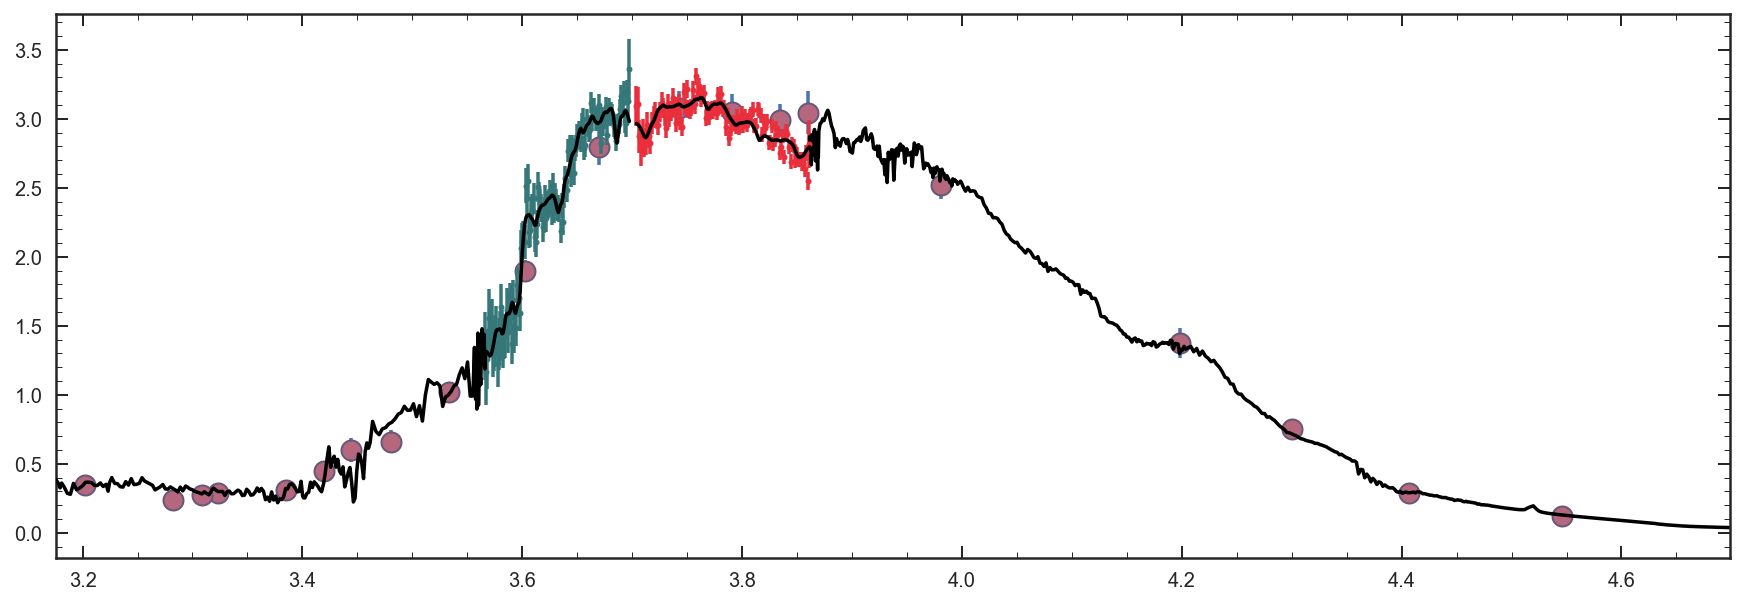

In [79]:
plt.figure(figsize=[15,5])
###############plot tab##################

if Gs.g102:
    plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
            linestyle='None', marker='o', markersize=3, color='#36787A', zorder = 2)
    plt.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4)

if Gs.g141:
    plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
            linestyle='None', marker='o', markersize=3, color='#EA2E3B', zorder = 2)
    plt.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4)

plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=10, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

plt.xlim(np.log10(1500),np.log10(50000))
IDB = [U for U in range(len(wave)) if wave[U] < Gs.Bwv_rf[0]]
IDR = [U for U in range(len(wave)) if wave[U] > Gs.Rwv_rf[-1]]

plt.plot(np.log10(wave)[IDB],SPEC[IDB]*1E18,'k', alpha = 1, label = 'Model', zorder=5)
plt.plot(np.log10(wave)[IDR],SPEC[IDR]*1E18,'k', alpha = 1)

(3.1760912590556813, 4.698970004336019)

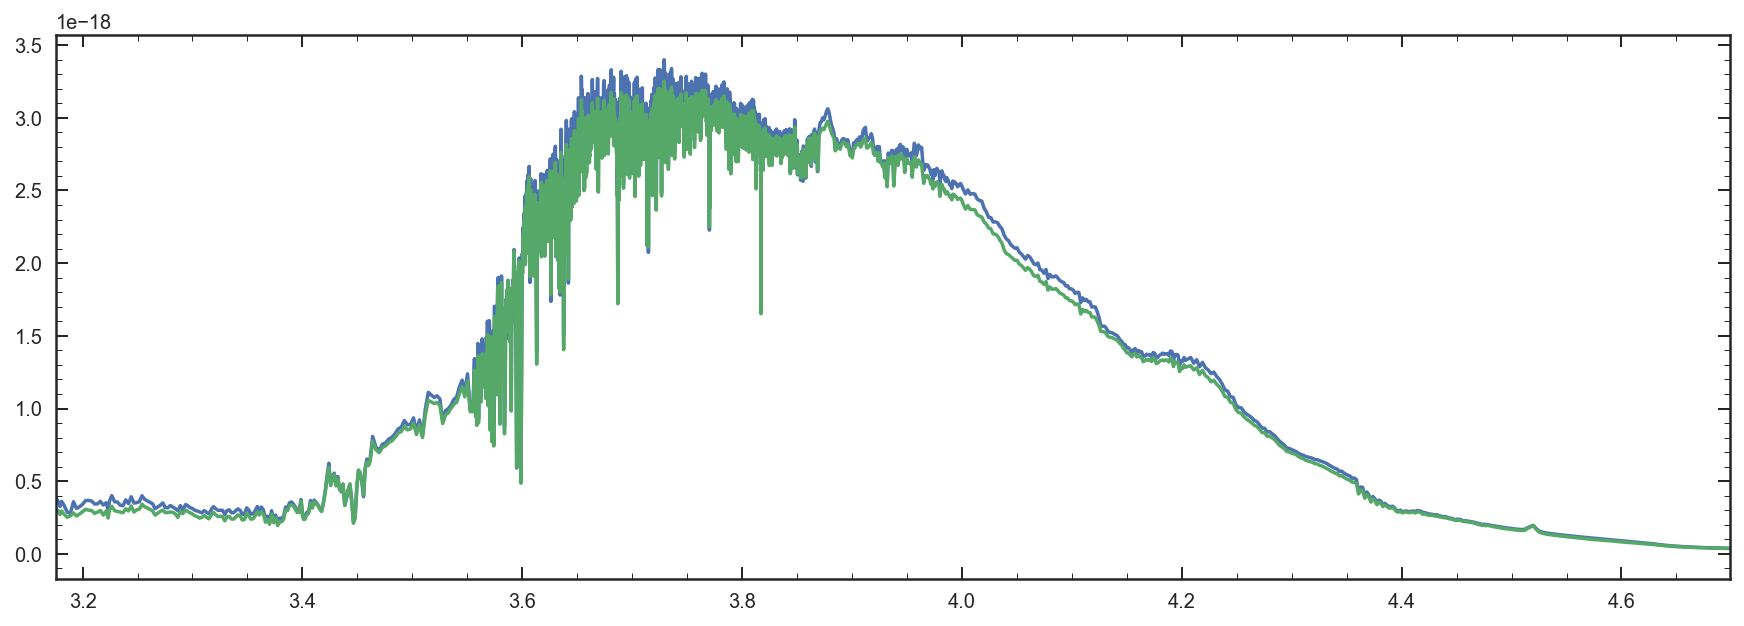

In [84]:
plt.figure(figsize=[15,5])

# plt.plot(np.log10(wave), flam)
plt.plot(np.log10(wave), SPEC)
plt.plot(np.log10(wave), flam)

plt.xlim(np.log10(1500),np.log10(50000))
